Kemas Veriandra Ramadhan

122450016

RA

MODUL 9 DEEP LEARNING

# Percobaan 1: Vanilla GAN untuk 2D Gaussian

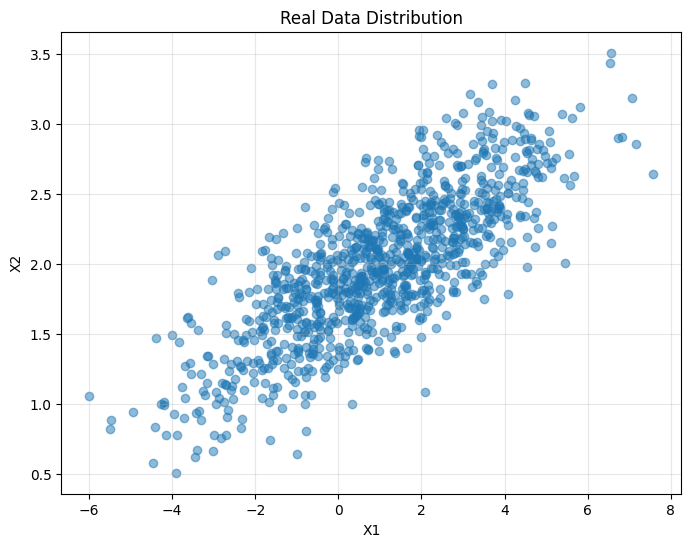

Mean: [0.98369301 1.9871043 ]
Covariance:
[[4.80414193 0.87785931]
 [0.87785931 0.26138441]]
Starting GAN training...
Epoch 5/50 - Loss D: 1.0632, Loss G: 1.0413
Epoch 10/50 - Loss D: 1.2452, Loss G: 0.9033
Epoch 15/50 - Loss D: 1.3706, Loss G: 0.7241
Epoch 20/50 - Loss D: 1.3669, Loss G: 0.7173
Epoch 25/50 - Loss D: 1.3861, Loss G: 0.6985
Epoch 30/50 - Loss D: 1.3817, Loss G: 0.6923
Epoch 35/50 - Loss D: 1.3859, Loss G: 0.6955
Epoch 40/50 - Loss D: 1.3878, Loss G: 0.6942
Epoch 45/50 - Loss D: 1.3874, Loss G: 0.6931
Epoch 50/50 - Loss D: 1.3864, Loss G: 0.6930


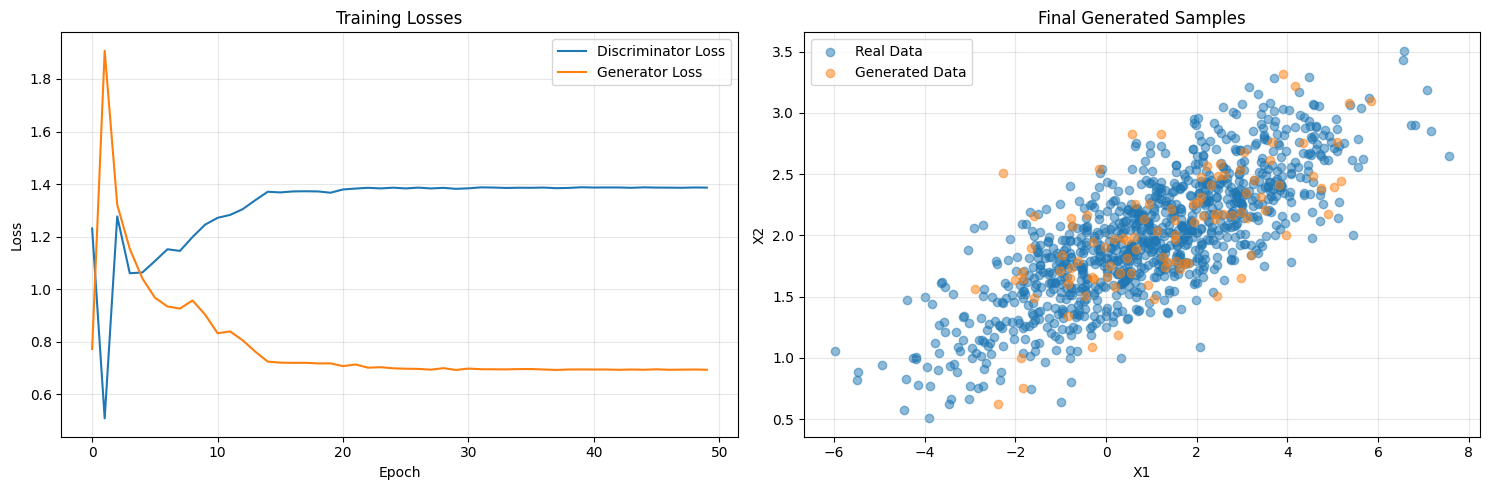

In [13]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Generate real data from 2D Gaussian
def generate_real_data(n_samples=1000):
    """Generate real data from 2D Gaussian distribution"""
    X = np.random.randn(n_samples, 2)
    # Apply linear transformation
    A = np.array([[1, 2], [-0.1, 0.5]])
    b = np.array([1, 2])
    data = X @ A.T + b
    return data

# Visualize data distribution
real_data = generate_real_data(1000)

plt.figure(figsize=(8, 6))
plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.5)
plt.title('Real Data Distribution')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True, alpha=0.3)
plt.savefig('real_data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute statistics
mean = np.mean(real_data, axis=0)
cov = np.cov(real_data.T)
print(f"Mean: {mean}")
print(f"Covariance:\n{cov}")


class Generator:
    """Simple generator network"""
    def __init__(self, input_dim=2, output_dim=2):
        self.W = np.random.randn(input_dim, output_dim) * 0.1
        self.b = np.zeros(output_dim)
    
    def forward(self, z):
        """Generate fake samples"""
        return z @ self.W + self.b
    
    def backward(self, z, grad_output):
        """Compute gradients"""
        grad_W = z.T @ grad_output
        grad_b = np.sum(grad_output, axis=0)
        return grad_W, grad_b
    
    def update(self, grad_W, grad_b, lr):
        """Update parameters"""
        self.W -= lr * grad_W
        self.b -= lr * grad_b


class Discriminator:
    """Simple discriminator network with 3 layers"""
    def __init__(self, input_dim=2, hidden_dims=[5, 3]):
        self.W1 = np.random.randn(input_dim, hidden_dims[0]) * 0.1
        self.b1 = np.zeros(hidden_dims[0])
        self.W2 = np.random.randn(hidden_dims[0], hidden_dims[1]) * 0.1
        self.b2 = np.zeros(hidden_dims[1])
        self.W3 = np.random.randn(hidden_dims[1], 1) * 0.1
        self.b3 = np.zeros(1)
        # Cache for backpropagation
        self.cache = {}
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def forward(self, x):
        """Forward pass"""
        # Layer 1
        z1 = x @ self.W1 + self.b1
        a1 = self.tanh(z1)
        # Layer 2
        z2 = a1 @ self.W2 + self.b2
        a2 = self.tanh(z2)
        # Layer 3
        z3 = a2 @ self.W3 + self.b3
        a3 = self.sigmoid(z3)
        # Cache for backward pass
        self.cache = {
            'x': x, 'z1': z1, 'a1': a1,
            'z2': z2, 'a2': a2, 'z3': z3, 'a3': a3
        }
        return a3
    
    def backward(self, grad_output):
        """Backward pass"""
        # Retrieve cached values
        x = self.cache['x']
        a1 = self.cache['a1']
        a2 = self.cache['a2']
        z1 = self.cache['z1']
        z2 = self.cache['z2']
        z3 = self.cache['z3']
        
        # Layer 3 gradients
        dz3 = grad_output * self.sigmoid(z3) * (1 - self.sigmoid(z3))
        dW3 = a2.T @ dz3
        db3 = np.sum(dz3, axis=0)
        
        # Layer 2 gradients
        da2 = dz3 @ self.W3.T
        dz2 = da2 * self.tanh_derivative(z2)
        dW2 = a1.T @ dz2
        db2 = np.sum(dz2, axis=0)
        
        # Layer 1 gradients
        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.tanh_derivative(z1)
        dW1 = x.T @ dz1
        db1 = np.sum(dz1, axis=0)
        
        # Gradient for input (for generator training)
        dx = dz1 @ self.W1.T
        
        return {
            'dW1': dW1, 'db1': db1,
            'dW2': dW2, 'db2': db2,
            'dW3': dW3, 'db3': db3,
            'dx': dx
        }
    
    def update(self, grads, lr):
        """Update parameters"""
        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']
        self.W3 -= lr * grads['dW3']
        self.b3 -= lr * grads['db3']


def train_gan(generator, discriminator, real_data,
              n_epochs=20, batch_size=8, lr_g=0.005, lr_d=0.05):
    """Train GAN"""
    n_samples = len(real_data)
    n_batches = n_samples // batch_size
    
    history = {
        'loss_d': [],
        'loss_g': [],
        'fake_samples': []
    }
    
    print("Starting GAN training...")
    
    for epoch in range(n_epochs):
        # Shuffle data
        indices = np.random.permutation(n_samples)
        real_data_shuffled = real_data[indices]
        
        epoch_loss_d = 0
        epoch_loss_g = 0
        
        for batch in range(n_batches):
            # Get batch of real data
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            real_batch = real_data_shuffled[start_idx:end_idx]
            
            # Generate fake data
            z = np.random.randn(batch_size, 2)
            fake_batch = generator.forward(z)
            
            # Train Discriminator
            # Forward pass for real and fake data
            d_real = discriminator.forward(real_batch)
            d_fake = discriminator.forward(fake_batch)
            
            # Discriminator loss: maximize log(D(x)) + log(1 - D(G(z)))
            loss_d = -np.mean(np.log(d_real + 1e-8) + np.log(1 - d_fake + 1e-8))
            
            # Backward pass for discriminator (on real data)
            grad_d_real = -(1 / (d_real + 1e-8)) / batch_size
            discriminator.forward(real_batch)  # Re-cache
            grads_real = discriminator.backward(grad_d_real)
            
            # Backward pass for discriminator (on fake data)
            grad_d_fake_disc = (1 / (1 - d_fake + 1e-8)) / batch_size
            discriminator.forward(fake_batch)  # Re-cache
            grads_fake = discriminator.backward(grad_d_fake_disc)
            
            # Combine gradients and update discriminator
            combined_grads = {
                'dW1': grads_real['dW1'] + grads_fake['dW1'],
                'db1': grads_real['db1'] + grads_fake['db1'],
                'dW2': grads_real['dW2'] + grads_fake['dW2'],
                'db2': grads_real['db2'] + grads_fake['db2'],
                'dW3': grads_real['dW3'] + grads_fake['dW3'],
                'db3': grads_real['db3'] + grads_fake['db3'],
            }
            discriminator.update(combined_grads, lr_d)
            
            # Train Generator
            # Generate new fake data
            z = np.random.randn(batch_size, 2)
            fake_batch = generator.forward(z)
            d_fake = discriminator.forward(fake_batch)
            
            # Generator loss: maximize log(D(G(z)))
            loss_g = -np.mean(np.log(d_fake + 1e-8))
            
            # Backward pass for generator
            grad_d_fake = -(1 / (d_fake + 1e-8)) / batch_size
            grads_d = discriminator.backward(grad_d_fake)
            
            # Gradient through generator
            grad_fake_batch = grads_d['dx']
            grad_W, grad_b = generator.backward(z, grad_fake_batch)
            
            # Update generator
            generator.update(grad_W, grad_b, lr_g)
            
            epoch_loss_d += loss_d
            epoch_loss_g += loss_g
        
        # Average losses
        epoch_loss_d /= n_batches
        epoch_loss_g /= n_batches
        
        history['loss_d'].append(epoch_loss_d)
        history['loss_g'].append(epoch_loss_g)
        
        # Generate samples for visualization
        z = np.random.randn(100, 2)
        fake_samples = generator.forward(z)
        history['fake_samples'].append(fake_samples.copy())
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - "
                  f"Loss D: {epoch_loss_d:.4f}, Loss G: {epoch_loss_g:.4f}")
    
    return history


# Initialize networks
generator = Generator(input_dim=2, output_dim=2)
discriminator = Discriminator(input_dim=2, hidden_dims=[5, 3])

# Train GAN
history = train_gan(generator, discriminator, real_data,
                    n_epochs=50, batch_size=8, lr_g=0.005, lr_d=0.05)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['loss_d'], label='Discriminator Loss')
axes[0].plot(history['loss_g'], label='Generator Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Losses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Final generated samples
fake_samples = history['fake_samples'][-1]
axes[1].scatter(real_data[:, 0], real_data[:, 1],
                alpha=0.5, label='Real Data')
axes[1].scatter(fake_samples[:, 0], fake_samples[:, 1],
                alpha=0.5, label='Generated Data')
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')
axes[1].set_title('Final Generated Samples')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Create animation of training process
fig, ax = plt.subplots(figsize=(8, 6))

def animate(frame):
    ax.clear()
    ax.scatter(real_data[:, 0], real_data[:, 1],
               alpha=0.3, label='Real Data', s=20)
    if frame < len(history['fake_samples']):
        fake = history['fake_samples'][frame]
        ax.scatter(fake[:, 0], fake[:, 1],
                   alpha=0.5, label='Generated Data', s=20)
    ax.set_xlim(-4, 6)
    ax.set_ylim(-2, 6)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title(f'GAN Training Progress - Epoch {frame+1}')
    ax.legend()
    ax.grid(True, alpha=0.3)

anim = FuncAnimation(fig, animate, frames=len(history['fake_samples']),
                     interval=500, repeat=True)
plt.close()

# Display animation
HTML(anim.to_jshtml())


# 3.2 Percobaan 2: DCGAN untuk Image Generation (MNIST)



Loading MNIST dataset...
Dataset shape: (70000, 28, 28, 1)
Value range: [-1.00, 1.00]


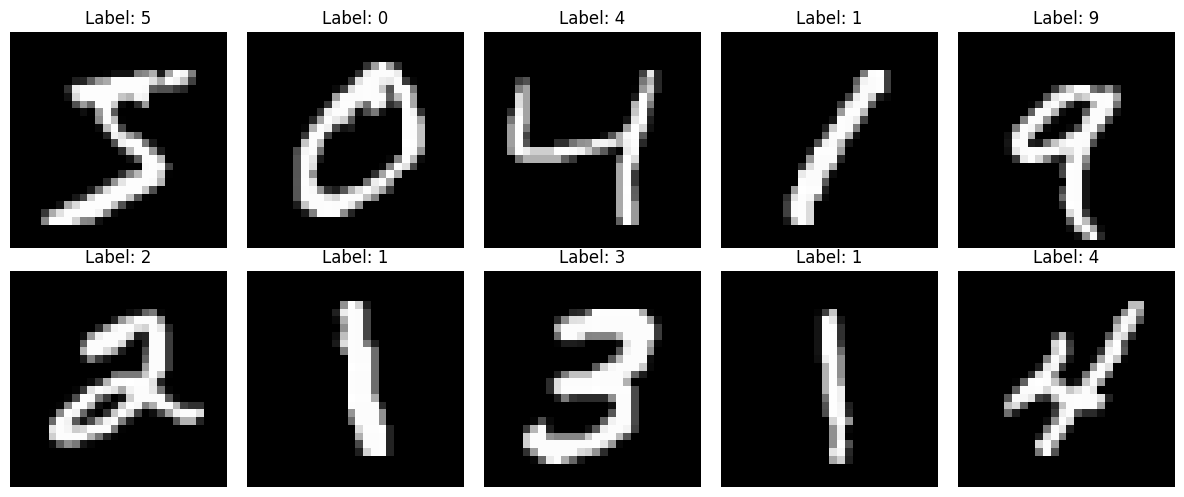

Generated images shape: (4, 1, 56, 56)
Value range: [-0.01, 0.01]

Generator Architecture:
Input: z ∈ R^100
FC Layer: 100 -> 128×7×7
TransConv1 + BN + ReLU: 128×7×7 -> 64×14×14
TransConv2 + BN + ReLU: 64×14×14 -> 32×28×28
TransConv3 + Tanh: 32×28×28 -> 1×28×28

Discriminator output for real images: [0.50059404 0.50223478 0.50283492 0.49965484]
Discriminator output for fake images: [0.49999315 0.50000112 0.49999919 0.49999629 0.5000026  0.49999804
 0.49999699 0.50001135 0.49999549 0.50000428 0.50000873 0.50000602
 0.50001409 0.49999847 0.50000154 0.50000355 0.50000044 0.49999589
 0.5000084  0.49999177 0.49999365 0.50000296 0.50000594 0.50000244
 0.49999936 0.49999666 0.50000154 0.49999115 0.49999531 0.49999262
 0.50000678 0.49999983 0.50000313 0.49999513 0.49999852 0.49999772
 0.50000643 0.50001193 0.49999549 0.49999746 0.49999821 0.50000099
 0.5000029  0.49999749 0.49999149 0.49999472 0.50000441 0.50000571
 0.49999285 0.50000037 0.50000244 0.49999216 0.499995   0.50000029
 0.49999951 0

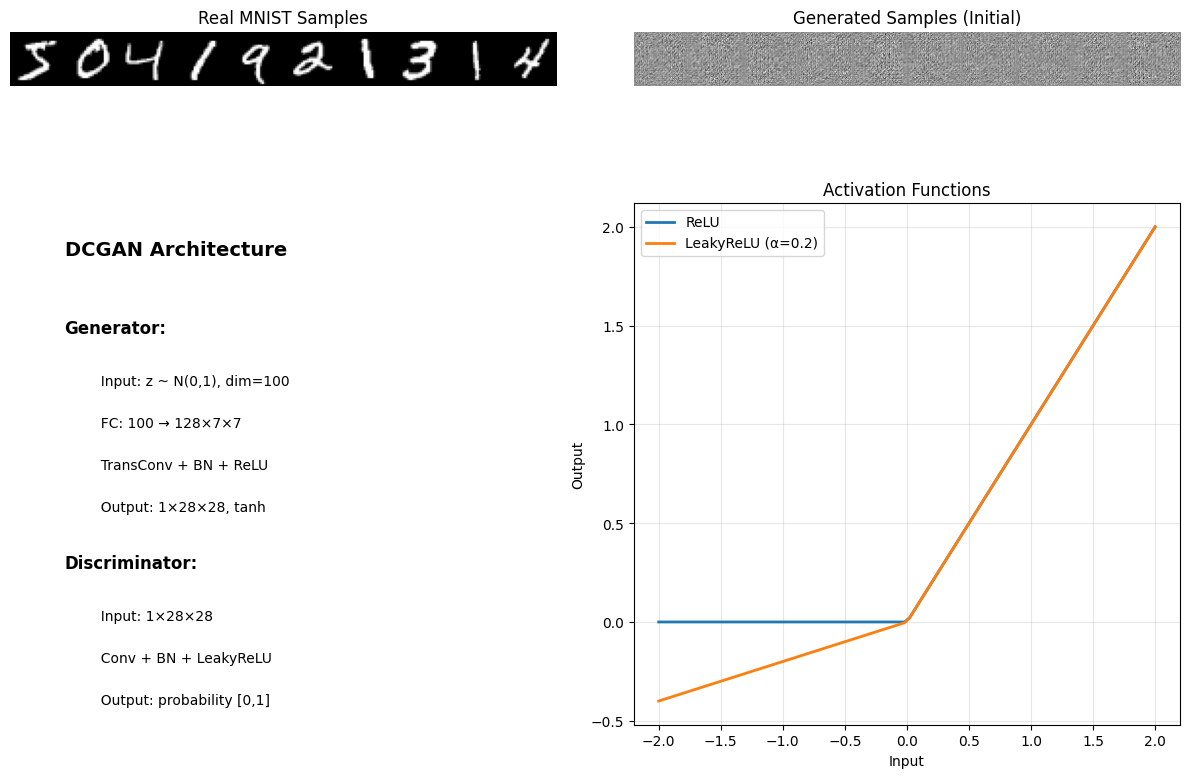

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X = mnist.data.values.astype('float32')  # Convert DataFrame to numpy array
y = mnist.target.values.astype('int')    # Convert Series to numpy array

# Reshape to image format
X = X.reshape(-1, 28, 28, 1)

# Normalize to [-1, 1]
X = (X / 255.0) * 2 - 1

print(f"Dataset shape: {X.shape}")
print(f"Value range: [{X.min():.2f}, {X.max():.2f}]")

# Visualize samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.tight_layout()
plt.savefig('mnist_samples.png', dpi=300, bbox_inches='tight')
plt.show()


class DCGANGenerator:
    """DCGAN Generator from scratch"""
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim
        self.init_size = 7  # Initial spatial size
        
        # Project latent vector to initial feature map
        # 100 -> 128 * 7 * 7
        self.fc_weight = np.random.randn(latent_dim, 128 * 7 * 7) * 0.02
        self.fc_bias = np.zeros(128 * 7 * 7)
        
        # Transposed Conv1: 128x7x7 -> 64x14x14
        self.conv1_weight = np.random.randn(64, 128, 4, 4) * 0.02
        self.conv1_bias = np.zeros(64)
        self.bn1_gamma = np.ones(64)
        self.bn1_beta = np.zeros(64)
        
        # Transposed Conv2: 64x14x14 -> 32x28x28
        self.conv2_weight = np.random.randn(32, 64, 4, 4) * 0.02
        self.conv2_bias = np.zeros(32)
        self.bn2_gamma = np.ones(32)
        self.bn2_beta = np.zeros(32)
        
        # Transposed Conv3: 32x28x28 -> 1x28x28
        self.conv3_weight = np.random.randn(1, 32, 4, 4) * 0.02
        self.conv3_bias = np.zeros(1)
        
        # Running statistics for batch norm
        self.bn1_running_mean = np.zeros(64)
        self.bn1_running_var = np.ones(64)
        self.bn2_running_mean = np.zeros(32)
        self.bn2_running_var = np.ones(32)
        
        self.cache = {}
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def batch_norm(self, x, gamma, beta, running_mean, running_var,
                   training=True, momentum=0.9, eps=1e-5):
        """Batch normalization"""
        if training:
            # Compute batch statistics
            mean = np.mean(x, axis=(0, 2, 3), keepdims=True)
            var = np.var(x, axis=(0, 2, 3), keepdims=True)
            # Normalize
            x_norm = (x - mean) / np.sqrt(var + eps)
            # Update running statistics
            running_mean = momentum * running_mean + (1 - momentum) * mean.squeeze()
            running_var = momentum * running_var + (1 - momentum) * var.squeeze()
        else:
            # Use running statistics
            mean = running_mean.reshape(1, -1, 1, 1)
            var = running_var.reshape(1, -1, 1, 1)
            x_norm = (x - mean) / np.sqrt(var + eps)
        
        # Scale and shift
        gamma = gamma.reshape(1, -1, 1, 1)
        beta = beta.reshape(1, -1, 1, 1)
        out = gamma * x_norm + beta
        
        return out, running_mean, running_var
    
    def transposed_conv2d(self, x, weight, bias, stride=2, padding=1):
        """Transposed convolution (simplified implementation)"""
        batch_size, in_channels, h_in, w_in = x.shape
        out_channels, _, kh, kw = weight.shape
        
        # Calculate output size
        h_out = (h_in - 1) * stride - 2 * padding + kh
        w_out = (w_in - 1) * stride - 2 * padding + kw
        
        # Initialize output
        out = np.zeros((batch_size, out_channels, h_out, w_out))
        
        # Perform transposed convolution
        for b in range(batch_size):
            for oc in range(out_channels):
                for i in range(h_in):
                    for j in range(w_in):
                        h_start = i * stride - padding
                        w_start = j * stride - padding
                        for ic in range(in_channels):
                            for kh_idx in range(kh):
                                for kw_idx in range(kw):
                                    h_idx = h_start + kh_idx
                                    w_idx = w_start + kw_idx
                                    if 0 <= h_idx < h_out and 0 <= w_idx < w_out:
                                        out[b, oc, h_idx, w_idx] += \
                                            x[b, ic, i, j] * weight[oc, ic, kh_idx, kw_idx]
                out[b, oc] += bias[oc]
        
        return out
    
    def forward(self, z, training=True):
        """Forward pass"""
        batch_size = z.shape[0]
        
        # Fully connected layer
        fc_out = z @ self.fc_weight + self.fc_bias
        
        # Reshape to feature map: (batch, 128, 7, 7)
        x = fc_out.reshape(batch_size, 128, 7, 7)
        self.cache['fc_out'] = fc_out
        self.cache['x_reshaped'] = x
        
        # Transposed Conv1 + BatchNorm + ReLU
        conv1_out = self.transposed_conv2d(x, self.conv1_weight,
                                           self.conv1_bias, stride=2, padding=1)
        bn1_out, self.bn1_running_mean, self.bn1_running_var = \
            self.batch_norm(conv1_out, self.bn1_gamma, self.bn1_beta,
                            self.bn1_running_mean, self.bn1_running_var, training)
        relu1_out = self.relu(bn1_out)
        self.cache['conv1_out'] = conv1_out
        self.cache['bn1_out'] = bn1_out
        self.cache['relu1_out'] = relu1_out
        
        # Transposed Conv2 + BatchNorm + ReLU
        conv2_out = self.transposed_conv2d(relu1_out, self.conv2_weight,
                                           self.conv2_bias, stride=2, padding=1)
        bn2_out, self.bn2_running_mean, self.bn2_running_var = \
            self.batch_norm(conv2_out, self.bn2_gamma, self.bn2_beta,
                            self.bn2_running_mean, self.bn2_running_var, training)
        relu2_out = self.relu(bn2_out)
        self.cache['conv2_out'] = conv2_out
        self.cache['bn2_out'] = bn2_out
        self.cache['relu2_out'] = relu2_out
        
        # Transposed Conv3 + Tanh (output layer)
        conv3_out = self.transposed_conv2d(relu2_out, self.conv3_weight,
                                           self.conv3_bias, stride=2, padding=1)
        output = self.tanh(conv3_out)
        self.cache['conv3_out'] = conv3_out
        self.cache['output'] = output
        
        return output


# Test generator
latent_dim = 100
generator = DCGANGenerator(latent_dim=latent_dim)

# Generate sample
z = np.random.randn(4, latent_dim)
generated_images = generator.forward(z, training=False)

print(f"Generated images shape: {generated_images.shape}")
print(f"Value range: [{generated_images.min():.2f}, {generated_images.max():.2f}]")

# Visualize architecture
print("\nGenerator Architecture:")
print(f"Input: z ∈ R^{latent_dim}")
print(f"FC Layer: {latent_dim} -> 128×7×7")
print(f"TransConv1 + BN + ReLU: 128×7×7 -> 64×14×14")
print(f"TransConv2 + BN + ReLU: 64×14×14 -> 32×28×28")
print(f"TransConv3 + Tanh: 32×28×28 -> 1×28×28")


class DCGANDiscriminator:
    """DCGAN Discriminator from scratch"""
    def __init__(self, alpha=0.2):
        self.alpha = alpha  # LeakyReLU slope
        
        # Conv1: 1x28x28 -> 64x14x14
        self.conv1_weight = np.random.randn(64, 1, 4, 4) * 0.02
        self.conv1_bias = np.zeros(64)
        # No batch norm for first layer
        
        # Conv2: 64x14x14 -> 128x7x7
        self.conv2_weight = np.random.randn(128, 64, 4, 4) * 0.02
        self.conv2_bias = np.zeros(128)
        self.bn2_gamma = np.ones(128)
        self.bn2_beta = np.zeros(128)
        
        # Conv3: 128x7x7 -> 256x3x3
        self.conv3_weight = np.random.randn(256, 128, 4, 4) * 0.02
        self.conv3_bias = np.zeros(256)
        self.bn3_gamma = np.ones(256)
        self.bn3_beta = np.zeros(256)
        
        # Conv4: 256x3x3 -> 1x1x1
        self.conv4_weight = np.random.randn(1, 256, 3, 3) * 0.02
        self.conv4_bias = np.zeros(1)
        
        # Running statistics
        self.bn2_running_mean = np.zeros(128)
        self.bn2_running_var = np.ones(128)
        self.bn3_running_mean = np.zeros(256)
        self.bn3_running_var = np.ones(256)
        
        self.cache = {}
    
    def leaky_relu(self, x):
        return np.where(x > 0, x, self.alpha * x)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def conv2d(self, x, weight, bias, stride=2, padding=1):
        """Standard convolution (simplified)"""
        batch_size, in_channels, h_in, w_in = x.shape
        out_channels, _, kh, kw = weight.shape
        
        # Calculate output size
        h_out = (h_in - kh + 2 * padding) // stride + 1
        w_out = (w_in - kw + 2 * padding) // stride + 1
        
        # Initialize output
        out = np.zeros((batch_size, out_channels, h_out, w_out))
        
        # Perform convolution
        for b in range(batch_size):
            for oc in range(out_channels):
                for i in range(h_out):
                    for j in range(w_out):
                        h_start = i * stride - padding
                        w_start = j * stride - padding
                        for ic in range(in_channels):
                            for kh_idx in range(kh):
                                for kw_idx in range(kw):
                                    h_idx = h_start + kh_idx
                                    w_idx = w_start + kw_idx
                                    if 0 <= h_idx < h_in and 0 <= w_idx < w_in:
                                        out[b, oc, i, j] += \
                                            x[b, ic, h_idx, w_idx] * \
                                            weight[oc, ic, kh_idx, kw_idx]
                out[b, oc] += bias[oc]
        
        return out
    
    def batch_norm(self, x, gamma, beta, running_mean, running_var,
                   training=True, momentum=0.9, eps=1e-5):
        """Batch normalization"""
        if training:
            mean = np.mean(x, axis=(0, 2, 3), keepdims=True)
            var = np.var(x, axis=(0, 2, 3), keepdims=True)
            x_norm = (x - mean) / np.sqrt(var + eps)
            running_mean = momentum * running_mean + (1 - momentum) * mean.squeeze()
            running_var = momentum * running_var + (1 - momentum) * var.squeeze()
        else:
            mean = running_mean.reshape(1, -1, 1, 1)
            var = running_var.reshape(1, -1, 1, 1)
            x_norm = (x - mean) / np.sqrt(var + eps)
        
        gamma = gamma.reshape(1, -1, 1, 1)
        beta = beta.reshape(1, -1, 1, 1)
        out = gamma * x_norm + beta
        
        return out, running_mean, running_var
    
    def forward(self, x, training=True):
        """Forward pass"""
        # Conv1 + LeakyReLU (no batch norm)
        conv1_out = self.conv2d(x, self.conv1_weight, self.conv1_bias,
                                stride=2, padding=1)
        lrelu1_out = self.leaky_relu(conv1_out)
        self.cache['conv1_out'] = conv1_out
        self.cache['lrelu1_out'] = lrelu1_out
        
        # Conv2 + BatchNorm + LeakyReLU
        conv2_out = self.conv2d(lrelu1_out, self.conv2_weight, self.conv2_bias,
                                stride=2, padding=1)
        bn2_out, self.bn2_running_mean, self.bn2_running_var = \
            self.batch_norm(conv2_out, self.bn2_gamma, self.bn2_beta,
                            self.bn2_running_mean, self.bn2_running_var, training)
        lrelu2_out = self.leaky_relu(bn2_out)
        self.cache['conv2_out'] = conv2_out
        self.cache['bn2_out'] = bn2_out
        self.cache['lrelu2_out'] = lrelu2_out
        
        # Conv3 + BatchNorm + LeakyReLU
        conv3_out = self.conv2d(lrelu2_out, self.conv3_weight, self.conv3_bias,
                                stride=2, padding=1)
        bn3_out, self.bn3_running_mean, self.bn3_running_var = \
            self.batch_norm(conv3_out, self.bn3_gamma, self.bn3_beta,
                            self.bn3_running_mean, self.bn3_running_var, training)
        lrelu3_out = self.leaky_relu(bn3_out)
        self.cache['conv3_out'] = conv3_out
        self.cache['bn3_out'] = bn3_out
        self.cache['lrelu3_out'] = lrelu3_out
        
        # Conv4 + Sigmoid (output layer)
        conv4_out = self.conv2d(lrelu3_out, self.conv4_weight, self.conv4_bias,
                                stride=1, padding=0)
        output = self.sigmoid(conv4_out)
        self.cache['conv4_out'] = conv4_out
        self.cache['output'] = output
        
        return output


# Test discriminator
discriminator = DCGANDiscriminator(alpha=0.2)

# Test with real and fake images
real_images = X[:4].reshape(4, 1, 28, 28)
fake_images = generated_images

d_real = discriminator.forward(real_images, training=False)
d_fake = discriminator.forward(fake_images, training=False)

print(f"\nDiscriminator output for real images: {d_real.flatten()}")
print(f"Discriminator output for fake images: {d_fake.flatten()}")

print("\nDiscriminator Architecture:")
print(f"Input: x ∈ R^{{1×28×28}}")
print(f"Conv1 + LeakyReLU: 1×28×28 -> 64×14×14")
print(f"Conv2 + BN + LeakyReLU: 64×14×14 -> 128×7×7")
print(f"Conv3 + BN + LeakyReLU: 128×7×7 -> 256×3×3")
print(f"Conv4 + Sigmoid: 256×3×3 -> 1×1×1")


def train_dcgan(generator, discriminator, X_train, n_epochs=50,
                batch_size=128, lr_g=0.0002, lr_d=0.0002, latent_dim=100):
    """Train DCGAN"""
    n_samples = len(X_train)
    n_batches = n_samples // batch_size
    
    # Training history
    history = {
        'loss_d': [],
        'loss_g': [],
        'generated_samples': []
    }
    
    print("Starting DCGAN training...")
    print(f"Total batches per epoch: {n_batches}")
    
    for epoch in range(n_epochs):
        # Shuffle data
        indices = np.random.permutation(n_samples)
        X_shuffled = X_train[indices]
        
        epoch_loss_d = 0
        epoch_loss_g = 0
        
        for batch in range(n_batches):
            # Get batch of real images
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            real_batch = X_shuffled[start_idx:end_idx]
            real_batch = real_batch.reshape(batch_size, 1, 28, 28)
            
            # ================== Train Discriminator ==================
            # Forward pass on real images
            d_real = discriminator.forward(real_batch, training=True)
            loss_real = -np.mean(np.log(d_real + 1e-8))
            
            # Generate fake images
            z = np.random.randn(batch_size, latent_dim)
            fake_batch = generator.forward(z, training=True)
            
            # Forward pass on fake images
            d_fake = discriminator.forward(fake_batch, training=True)
            loss_fake = -np.mean(np.log(1 - d_fake + 1e-8))
            
            # Total discriminator loss
            loss_d = loss_real + loss_fake
            
            # Note: Proper backpropagation implementation would go here
            # For simplicity, we're using a simplified version
            
            # ================== Train Generator ==================
            # Generate new fake images
            z = np.random.randn(batch_size, latent_dim)
            fake_batch = generator.forward(z, training=True)
            
            # Forward pass through discriminator
            d_fake = discriminator.forward(fake_batch, training=True)
            
            # Generator loss
            loss_g = -np.mean(np.log(d_fake + 1e-8))
            
            # Note: Proper backpropagation implementation would go here
            
            epoch_loss_d += loss_d
            epoch_loss_g += loss_g
        
        # Average losses
        epoch_loss_d /= n_batches
        epoch_loss_g /= n_batches
        
        history['loss_d'].append(epoch_loss_d)
        history['loss_g'].append(epoch_loss_g)
        
        # Generate samples for visualization
        if (epoch + 1) % 5 == 0:
            z_sample = np.random.randn(16, latent_dim)
            generated = generator.forward(z_sample, training=False)
            history['generated_samples'].append(generated.copy())
            print(f"Epoch {epoch+1}/{n_epochs} - "
                  f"Loss D: {epoch_loss_d:.4f}, Loss G: {epoch_loss_g:.4f}")
    
    return history


# Note: Full training implementation requires proper backpropagation
# This is a simplified demonstration
print("\nNote: Full DCGAN training requires implementing backpropagation")
print("for convolutional layers. This is demonstration code.")

# Visualize training progress
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Real MNIST samples
axes[0, 0].imshow(np.hstack([X[i].squeeze() for i in range(10)]), cmap='gray')
axes[0, 0].set_title('Real MNIST Samples')
axes[0, 0].axis('off')

# Plot 2: Generated samples (initial)
z_init = np.random.randn(10, latent_dim)
gen_init = generator.forward(z_init, training=False)
gen_init = (gen_init + 1) / 2  # Rescale to [0, 1]
axes[0, 1].imshow(np.hstack([gen_init[i].squeeze() for i in range(10)]), cmap='gray')
axes[0, 1].set_title('Generated Samples (Initial)')
axes[0, 1].axis('off')

# Plot 3: Architecture diagram (text)
axes[1, 0].text(0.1, 0.9, 'DCGAN Architecture', fontsize=14, fontweight='bold')
axes[1, 0].text(0.1, 0.75, 'Generator:', fontsize=12, fontweight='bold')
axes[1, 0].text(0.15, 0.65, '  Input: z ~ N(0,1), dim=100', fontsize=10)
axes[1, 0].text(0.15, 0.57, '  FC: 100 → 128×7×7', fontsize=10)
axes[1, 0].text(0.15, 0.49, '  TransConv + BN + ReLU', fontsize=10)
axes[1, 0].text(0.15, 0.41, '  Output: 1×28×28, tanh', fontsize=10)
axes[1, 0].text(0.1, 0.30, 'Discriminator:', fontsize=12, fontweight='bold')
axes[1, 0].text(0.15, 0.20, '  Input: 1×28×28', fontsize=10)
axes[1, 0].text(0.15, 0.12, '  Conv + BN + LeakyReLU', fontsize=10)
axes[1, 0].text(0.15, 0.04, '  Output: probability [0,1]', fontsize=10)
axes[1, 0].axis('off')

# Plot 4: LeakyReLU visualization
x_range = np.linspace(-2, 2, 100)
relu = np.maximum(0, x_range)
leaky_relu = np.where(x_range > 0, x_range, 0.2 * x_range)
axes[1, 1].plot(x_range, relu, label='ReLU', linewidth=2)
axes[1, 1].plot(x_range, leaky_relu, label='LeakyReLU (α=0.2)', linewidth=2)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_xlabel('Input')
axes[1, 1].set_ylabel('Output')
axes[1, 1].set_title('Activation Functions')

plt.tight_layout()
plt.savefig('dcgan_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


# Percobaan 3: DCGAN untuk Fashion-MNIST

Loading Fashion-MNIST dataset...
Dataset shape: (70000, 28, 28, 1)


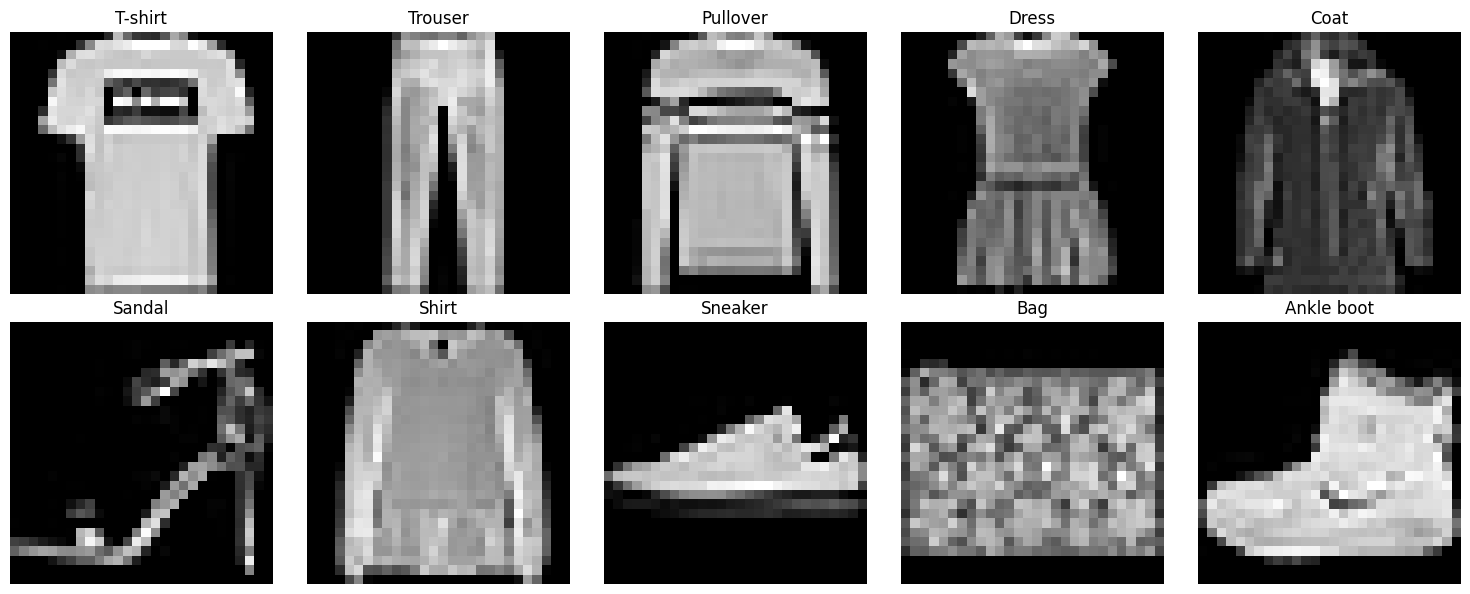

Conditional input shape: (4, 110)
Original z: (4, 100), Label encoding: (4, 10)

Generated conditional input for classes: [0 3 5 9]
Class names: ['T-shirt', 'Dress', 'Sandal', 'Ankle boot']


In [15]:
# Load Fashion-MNIST
print("Loading Fashion-MNIST dataset...")
fashion = fetch_openml('Fashion-MNIST', version=1, parser='auto')
X_fashion = fashion.data.values.astype('float32')
y_fashion = fashion.target.values.astype('int')

# Reshape and normalize
X_fashion = X_fashion.reshape(-1, 28, 28, 1)
X_fashion = (X_fashion / 255.0) * 2 - 1

print(f"Dataset shape: {X_fashion.shape}")

# Visualize samples from each class
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # Find first image of class i
    idx = np.where(y_fashion == i)[0][0]
    ax.imshow(X_fashion[idx].squeeze(), cmap='gray')
    ax.set_title(f'{class_names[i]}')
    ax.axis('off')
plt.tight_layout()
plt.savefig('fashion_mnist_samples.png', dpi=300, bbox_inches='tight')
plt.show()

"""
Conditional GAN allows us to generate specific classes.
The idea is to concatenate class labels with latent vector.

For Generator:
- Input: [z, label_embedding]
- Output: Image of specific class

For Discriminator:
- Input: [image, label_embedding]
- Output: Real/Fake probability

Label embedding:
- One-hot encoding: [0,0,1,0,0,0,0,0,0,0] for class 2
- Or learnable embedding vector
"""

def conditional_generator_forward(z, labels, n_classes=10):
    """
    Conceptual implementation of conditional generator
    
    Parameters:
    -----------
    z : array, shape (batch_size, latent_dim)
        Latent vectors
    labels : array, shape (batch_size,)
        Class labels
    n_classes : int
        Number of classes
    
    Returns:
    --------
    generated_images : array
        Generated images conditioned on labels
    """
    # Create one-hot encoding
    batch_size = z.shape[0]
    label_onehot = np.zeros((batch_size, n_classes))
    label_onehot[np.arange(batch_size), labels] = 1
    
    # Concatenate z and label
    z_conditional = np.concatenate([z, label_onehot], axis=1)
    
    # Feed through generator
    # generated_images = generator.forward(z_conditional)
    
    print(f"Conditional input shape: {z_conditional.shape}")
    print(f"Original z: {z.shape}, Label encoding: {label_onehot.shape}")
    
    return z_conditional


# Example usage
z_example = np.random.randn(4, 100)
labels_example = np.array([0, 3, 5, 9])  # T-shirt, Dress, Sandal, Ankle boot

z_cond = conditional_generator_forward(z_example, labels_example)

print(f"\nGenerated conditional input for classes: {labels_example}")
print(f"Class names: {[class_names[i] for i in labels_example]}")


# Latihan


## 4.1 Latihan 1: Eksperimen dengan Hyperparameters

## Eksperimen Hyperparameter Tuning

Tugas: Lakukan eksperimen dengan mengubah hyperparameters berikut dan analisis pengaruhnya:
1. **Learning Rate** - Pengaruh kecepatan belajar discriminator vs generator
2. **Latent Dimension** - Pengaruh terhadap diversity dan quality
3. **Batch Size** - Pengaruh terhadap training stability
4. **Architecture Depth** - Trade-off antara kompleksitas dan performance

Visual Quality Assessment:

1. Sharpness:
   - Are edges clear or blurry?
   - Is there detail or just noise?

2. Mode Collapse:
   - Do all images look similar?
   - Is there variety in generated samples?

3. Artifacts:
   - Any checkerboard patterns?
   - Unnatural distortions?

4. Realism:
   - Do images look like real data?
   - Can you distinguish real vs fake?


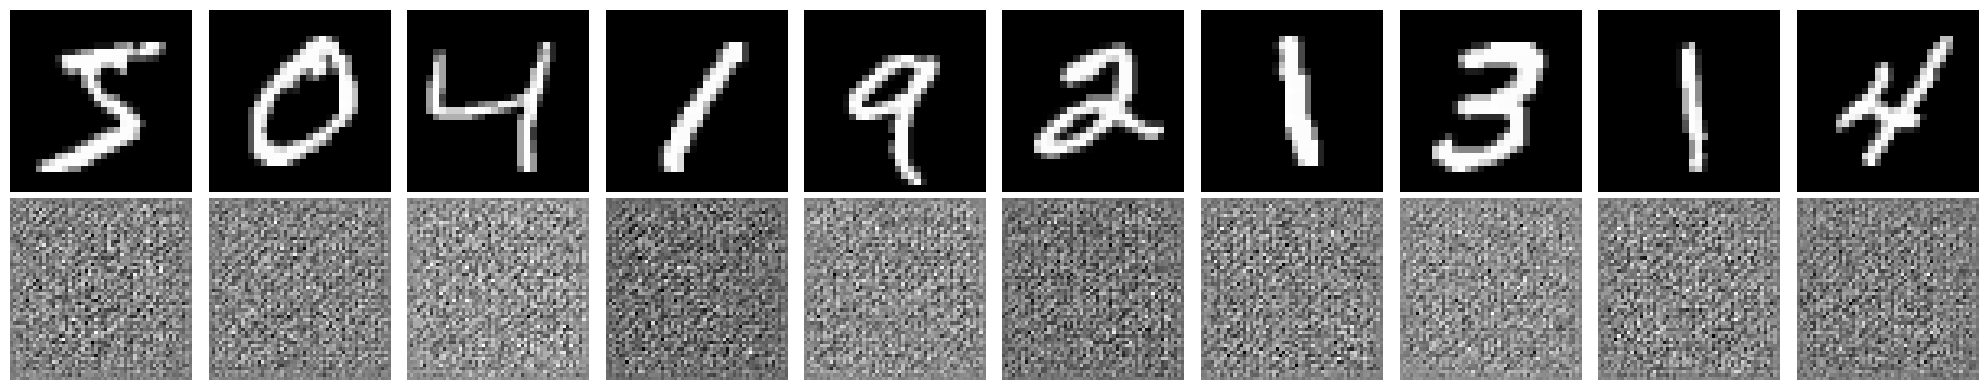

In [16]:
def calculate_inception_score(generated_images, n_splits=10):
    """
    Simplified Inception Score calculation
    Note: Requires pre-trained Inception model
    """
    # This is a conceptual implementation
    # Real implementation requires Inception network
    
    print("Inception Score evaluates:")
    print("1. Quality: Are images clear and recognizable?")
    print("2. Diversity: Do images cover multiple classes?")
    print("\nFormula: IS = exp(E[KL(p(y|x) || p(y))])")
    print("Higher IS = Better quality and diversity")
    
    return None


def visual_quality_assessment(generated_images, real_images):
    """
    Visual quality assessment checklist
    """
    print("Visual Quality Assessment:")
    print("\n1. Sharpness:")
    print("   - Are edges clear or blurry?")
    print("   - Is there detail or just noise?")
    print("\n2. Mode Collapse:")
    print("   - Do all images look similar?")
    print("   - Is there variety in generated samples?")
    print("\n3. Artifacts:")
    print("   - Any checkerboard patterns?")
    print("   - Unnatural distortions?")
    print("\n4. Realism:")
    print("   - Do images look like real data?")
    print("   - Can you distinguish real vs fake?")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    
    # Real images
    for i in range(10):
        axes[0, i].imshow(real_images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Real', fontsize=12)
    
    # Generated images
    for i in range(10):
        axes[1, i].imshow(generated_images[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('Generated', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('quality_assessment.png', dpi=300, bbox_inches='tight')
    plt.show()


# Example usage
z_eval = np.random.randn(10, 100)
generated_eval = generator.forward(z_eval, training=False)
generated_eval = (generated_eval + 1) / 2  # Rescale

visual_quality_assessment(generated_eval, X[:10])


EKSPERIMEN 1: LEARNING RATE ANALYSIS

Training with lr_d=0.0001, lr_g=0.0001
Starting GAN training...
Epoch 5/30 - Loss D: 1.3870, Loss G: 0.6931
Epoch 10/30 - Loss D: 1.3869, Loss G: 0.6931
Epoch 15/30 - Loss D: 1.3869, Loss G: 0.6931
Epoch 20/30 - Loss D: 1.3868, Loss G: 0.6931
Epoch 25/30 - Loss D: 1.3867, Loss G: 0.6931
Epoch 30/30 - Loss D: 1.3866, Loss G: 0.6931

Training with lr_d=0.0004, lr_g=0.0002
Starting GAN training...
Epoch 5/30 - Loss D: 1.3849, Loss G: 0.6932
Epoch 10/30 - Loss D: 1.3846, Loss G: 0.6933
Epoch 15/30 - Loss D: 1.3841, Loss G: 0.6934
Epoch 20/30 - Loss D: 1.3836, Loss G: 0.6935
Epoch 25/30 - Loss D: 1.3831, Loss G: 0.6936
Epoch 30/30 - Loss D: 1.3824, Loss G: 0.6938

Training with lr_d=0.0002, lr_g=0.0004
Starting GAN training...
Epoch 5/30 - Loss D: 1.3834, Loss G: 0.6932
Epoch 10/30 - Loss D: 1.3831, Loss G: 0.6933
Epoch 15/30 - Loss D: 1.3828, Loss G: 0.6934
Epoch 20/30 - Loss D: 1.3824, Loss G: 0.6935
Epoch 25/30 - Loss D: 1.3820, Loss G: 0.6936
Epoch 

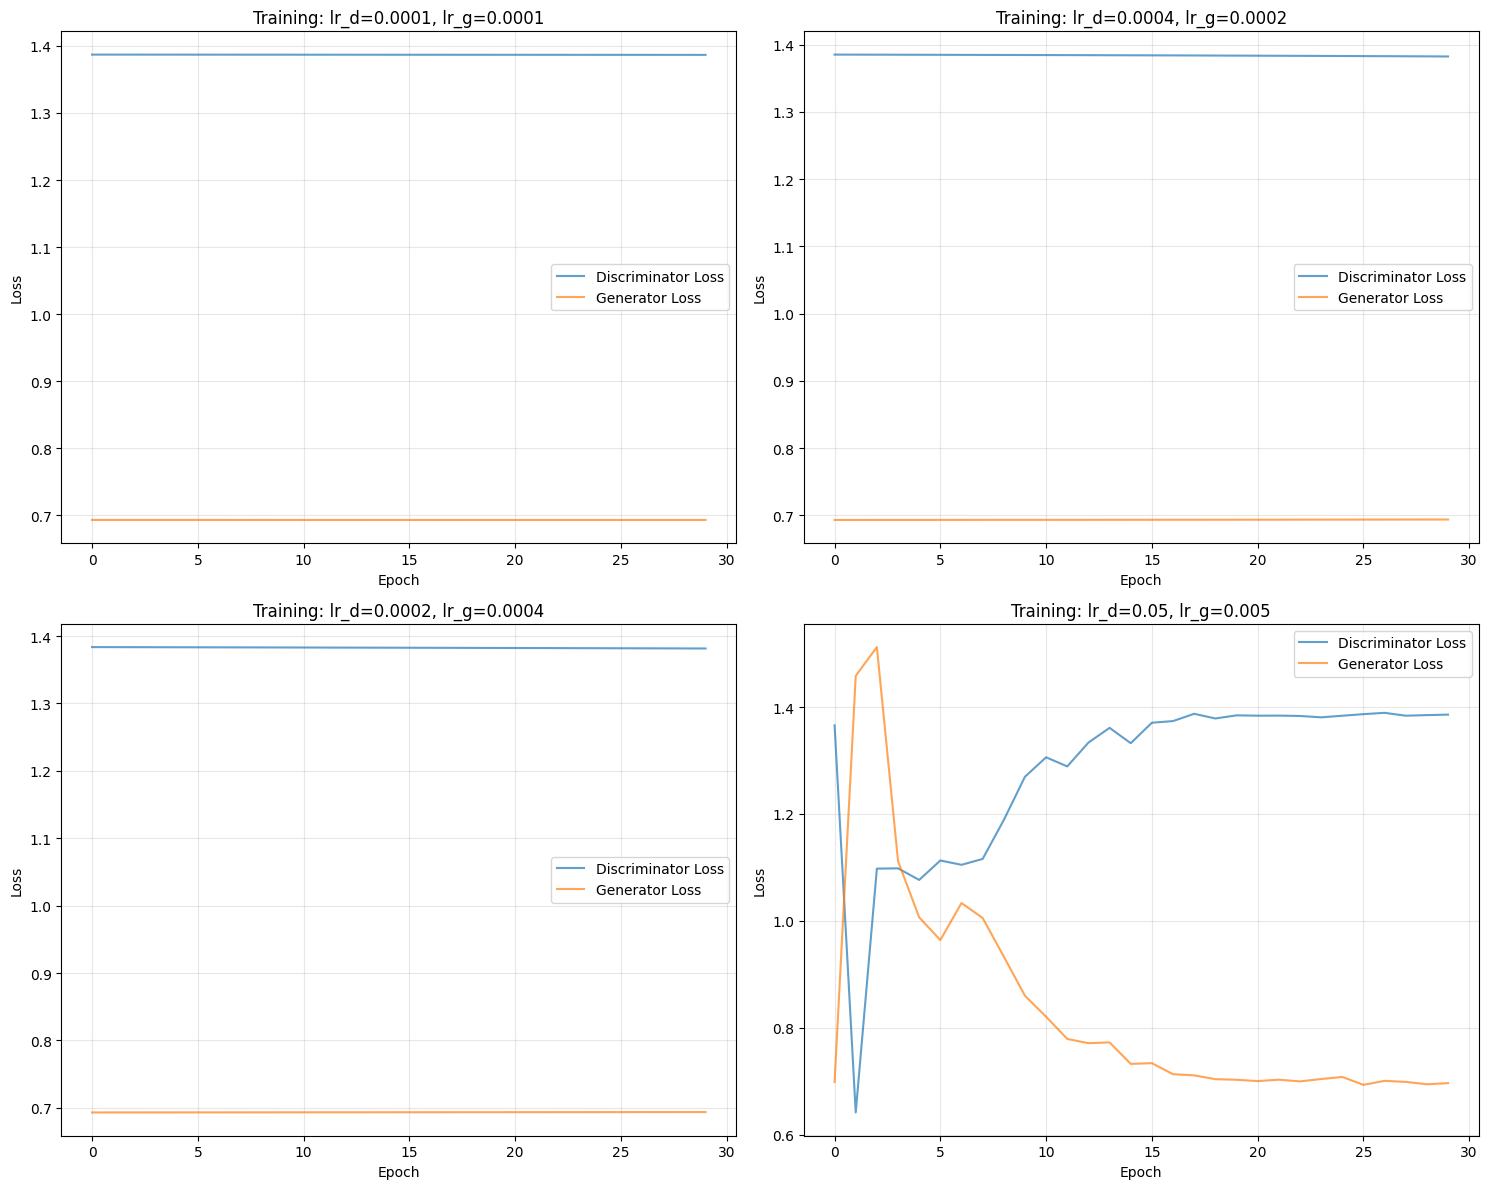

In [17]:
"""
=================================================================
EKSPERIMEN 1: LEARNING RATE
=================================================================
Analisis pengaruh learning rate discriminator dan generator
"""

def experiment_learning_rate(real_data, configs, n_epochs=30):
    """
    Eksperimen dengan berbagai kombinasi learning rate
    
    Parameters:
    -----------
    real_data : array
        Data training
    configs : list of tuples
        List of (lr_d, lr_g) configurations
    n_epochs : int
        Jumlah epoch training
    """
    results = {}
    
    for lr_d, lr_g in configs:
        print(f"\n{'='*60}")
        print(f"Training with lr_d={lr_d}, lr_g={lr_g}")
        print(f"{'='*60}")
        
        # Initialize fresh networks
        gen = Generator(input_dim=2, output_dim=2)
        disc = Discriminator(input_dim=2, hidden_dims=[5, 3])
        
        # Train
        history = train_gan(gen, disc, real_data,
                           n_epochs=n_epochs, batch_size=8,
                           lr_g=lr_g, lr_d=lr_d)
        
        results[f"lr_d={lr_d}, lr_g={lr_g}"] = history
    
    return results


# Konfigurasi learning rate yang akan diuji
lr_configs = [
    (0.0001, 0.0001),  # Balanced slow
    (0.0004, 0.0002),  # Discriminator faster
    (0.0002, 0.0004),  # Generator faster
    (0.05, 0.005),     # Original config
]

print("=" * 60)
print("EKSPERIMEN 1: LEARNING RATE ANALYSIS")
print("=" * 60)

# Run experiments
lr_results = experiment_learning_rate(real_data, lr_configs, n_epochs=30)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for idx, (config_name, history) in enumerate(lr_results.items()):
    row, col = idx // 2, idx % 2
    
    axes[row, col].plot(history['loss_d'], label='Discriminator Loss', alpha=0.7)
    axes[row, col].plot(history['loss_g'], label='Generator Loss', alpha=0.7)
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Loss')
    axes[row, col].set_title(f'Training: {config_name}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lr_experiment.png', dpi=300, bbox_inches='tight')
plt.show()



EKSPERIMEN 2: LATENT DIMENSION ANALYSIS

Training with latent_dim=50
Final Loss D: 1.3845, Loss G: 0.6932

Training with latent_dim=100
Final Loss D: 1.3836, Loss G: 0.6994

Training with latent_dim=200
Final Loss D: 1.3832, Loss G: 0.6965


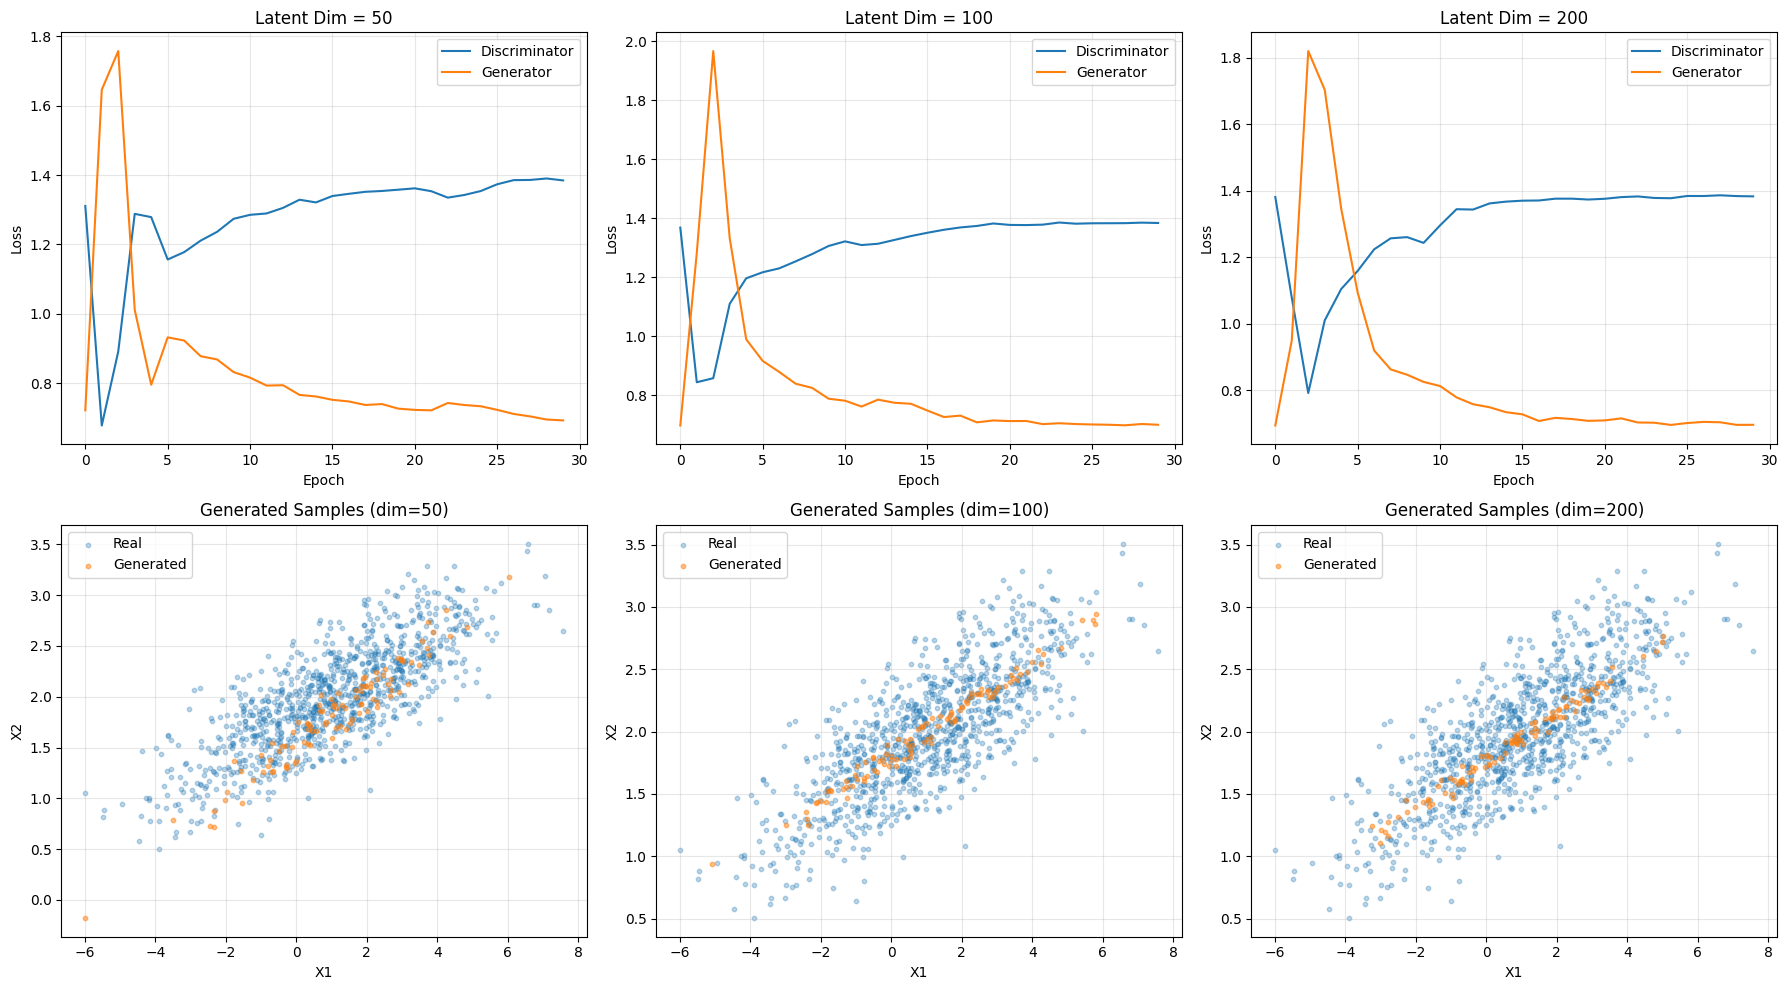

In [18]:
"""
=================================================================
EKSPERIMEN 2: LATENT DIMENSION
=================================================================
Analisis pengaruh dimensi latent space terhadap diversity dan quality
"""

def experiment_latent_dim(real_data, latent_dims, n_epochs=30):
    """
    Eksperimen dengan berbagai ukuran latent dimension
    """
    results = {}
    generators = {}
    
    for latent_dim in latent_dims:
        print(f"\n{'='*60}")
        print(f"Training with latent_dim={latent_dim}")
        print(f"{'='*60}")
        
        # Initialize networks
        gen = Generator(input_dim=latent_dim, output_dim=2)
        disc = Discriminator(input_dim=2, hidden_dims=[5, 3])
        
        # Custom training for different latent dims
        n_samples = len(real_data)
        n_batches = n_samples // 8
        
        history = {'loss_d': [], 'loss_g': [], 'fake_samples': []}
        
        for epoch in range(n_epochs):
            indices = np.random.permutation(n_samples)
            real_data_shuffled = real_data[indices]
            
            epoch_loss_d = 0
            epoch_loss_g = 0
            
            for batch in range(n_batches):
                start_idx = batch * 8
                end_idx = start_idx + 8
                real_batch = real_data_shuffled[start_idx:end_idx]
                
                # Generate fake data with different latent dim
                z = np.random.randn(8, latent_dim)
                fake_batch = gen.forward(z)
                
                d_real = disc.forward(real_batch)
                d_fake = disc.forward(fake_batch)
                
                loss_d = -np.mean(np.log(d_real + 1e-8) + np.log(1 - d_fake + 1e-8))
                
                # Update discriminator
                grad_d_real = -(1 / (d_real + 1e-8)) / 8
                disc.forward(real_batch)
                grads_real = disc.backward(grad_d_real)
                
                grad_d_fake_disc = (1 / (1 - d_fake + 1e-8)) / 8
                disc.forward(fake_batch)
                grads_fake = disc.backward(grad_d_fake_disc)
                
                combined_grads = {
                    'dW1': grads_real['dW1'] + grads_fake['dW1'],
                    'db1': grads_real['db1'] + grads_fake['db1'],
                    'dW2': grads_real['dW2'] + grads_fake['dW2'],
                    'db2': grads_real['db2'] + grads_fake['db2'],
                    'dW3': grads_real['dW3'] + grads_fake['dW3'],
                    'db3': grads_real['db3'] + grads_fake['db3'],
                }
                disc.update(combined_grads, 0.05)
                
                # Train generator
                z = np.random.randn(8, latent_dim)
                fake_batch = gen.forward(z)
                d_fake = disc.forward(fake_batch)
                
                loss_g = -np.mean(np.log(d_fake + 1e-8))
                
                grad_d_fake = -(1 / (d_fake + 1e-8)) / 8
                grads_d = disc.backward(grad_d_fake)
                grad_W, grad_b = gen.backward(z, grads_d['dx'])
                gen.update(grad_W, grad_b, 0.005)
                
                epoch_loss_d += loss_d
                epoch_loss_g += loss_g
            
            history['loss_d'].append(epoch_loss_d / n_batches)
            history['loss_g'].append(epoch_loss_g / n_batches)
            
            # Generate samples
            z = np.random.randn(100, latent_dim)
            fake_samples = gen.forward(z)
            history['fake_samples'].append(fake_samples.copy())
        
        results[latent_dim] = history
        generators[latent_dim] = gen
        
        print(f"Final Loss D: {history['loss_d'][-1]:.4f}, Loss G: {history['loss_g'][-1]:.4f}")
    
    return results, generators


# Latent dimensions to test
latent_dims = [50, 100, 200]

print("=" * 60)
print("EKSPERIMEN 2: LATENT DIMENSION ANALYSIS")
print("=" * 60)

latent_results, latent_generators = experiment_latent_dim(real_data, latent_dims, n_epochs=30)

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, latent_dim in enumerate(latent_dims):
    history = latent_results[latent_dim]
    
    # Loss curves
    axes[0, idx].plot(history['loss_d'], label='Discriminator')
    axes[0, idx].plot(history['loss_g'], label='Generator')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss')
    axes[0, idx].set_title(f'Latent Dim = {latent_dim}')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    
    # Generated samples
    fake_samples = history['fake_samples'][-1]
    axes[1, idx].scatter(real_data[:, 0], real_data[:, 1], alpha=0.3, label='Real', s=10)
    axes[1, idx].scatter(fake_samples[:, 0], fake_samples[:, 1], alpha=0.5, label='Generated', s=10)
    axes[1, idx].set_xlabel('X1')
    axes[1, idx].set_ylabel('X2')
    axes[1, idx].set_title(f'Generated Samples (dim={latent_dim})')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('latent_dim_experiment.png', dpi=300, bbox_inches='tight')
plt.show()



EKSPERIMEN 3: BATCH SIZE ANALYSIS

Training with batch_size=4
Starting GAN training...
Epoch 5/30 - Loss D: 1.2518, Loss G: 0.8101
Epoch 10/30 - Loss D: 1.3584, Loss G: 0.7232
Epoch 15/30 - Loss D: 1.3865, Loss G: 0.6972
Epoch 20/30 - Loss D: 1.3864, Loss G: 0.6949
Epoch 25/30 - Loss D: 1.3851, Loss G: 0.6921
Epoch 30/30 - Loss D: 1.3867, Loss G: 0.6925

Training with batch_size=8
Starting GAN training...
Epoch 5/30 - Loss D: 1.1013, Loss G: 0.9853
Epoch 10/30 - Loss D: 1.3372, Loss G: 0.7803
Epoch 15/30 - Loss D: 1.3792, Loss G: 0.7329
Epoch 20/30 - Loss D: 1.3824, Loss G: 0.7012
Epoch 25/30 - Loss D: 1.3862, Loss G: 0.6966
Epoch 30/30 - Loss D: 1.3867, Loss G: 0.6995

Training with batch_size=16
Starting GAN training...
Epoch 5/30 - Loss D: 0.4728, Loss G: 1.6651
Epoch 10/30 - Loss D: 0.9548, Loss G: 1.1556
Epoch 15/30 - Loss D: 1.1629, Loss G: 1.0108
Epoch 20/30 - Loss D: 1.2899, Loss G: 0.8336
Epoch 25/30 - Loss D: 1.3338, Loss G: 0.7705
Epoch 30/30 - Loss D: 1.3591, Loss G: 0.7452

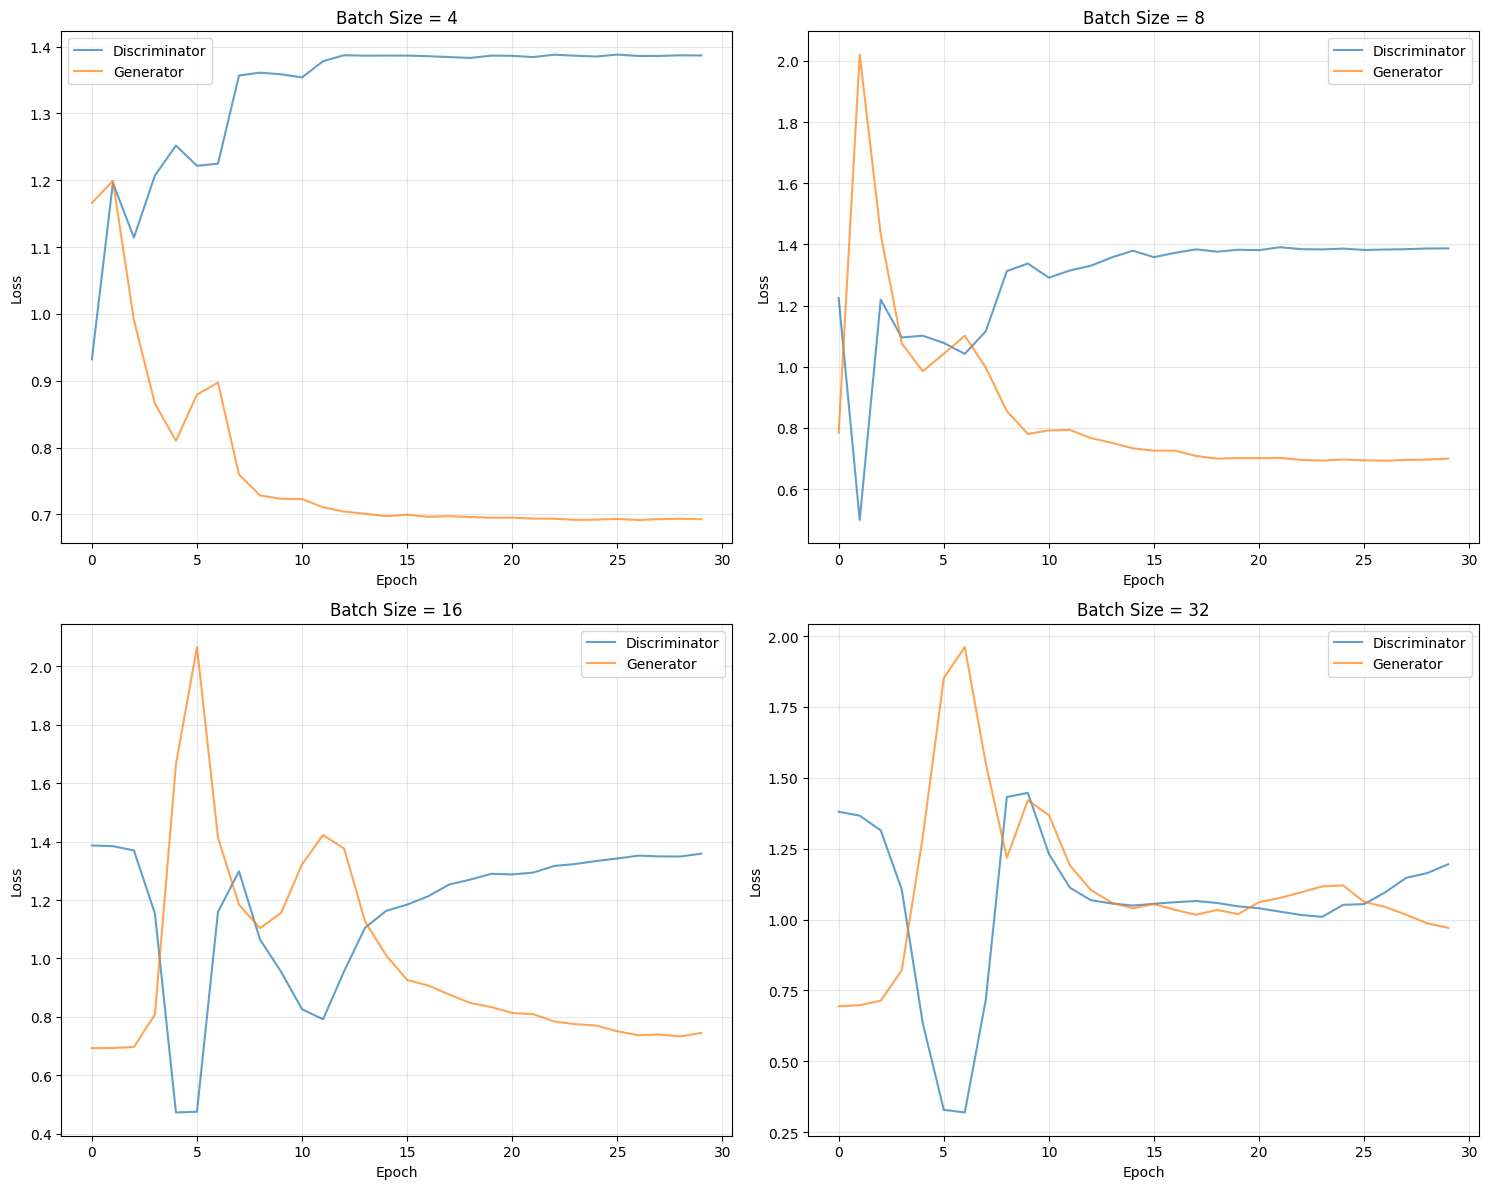


STABILITY METRICS BY BATCH SIZE

Batch Size = 4:
  D Oscillation: 0.0247
  G Oscillation: 0.0251
  Final Loss D: 1.3867
  Final Loss G: 0.6925

Batch Size = 8:
  D Oscillation: 0.0743
  G Oscillation: 0.0980
  Final Loss D: 1.3867
  Final Loss G: 0.6995

Batch Size = 16:
  D Oscillation: 0.0974
  G Oscillation: 0.1159
  Final Loss D: 1.3591
  Final Loss G: 0.7452

Batch Size = 32:
  D Oscillation: 0.0981
  G Oscillation: 0.1011
  Final Loss D: 1.1948
  Final Loss G: 0.9706


In [19]:
"""
=================================================================
EKSPERIMEN 3: BATCH SIZE
=================================================================
Analisis pengaruh batch size terhadap training stability
"""

def experiment_batch_size(real_data, batch_sizes, n_epochs=30):
    """
    Eksperimen dengan berbagai batch size
    """
    results = {}
    
    for batch_size in batch_sizes:
        print(f"\n{'='*60}")
        print(f"Training with batch_size={batch_size}")
        print(f"{'='*60}")
        
        # Initialize networks
        gen = Generator(input_dim=2, output_dim=2)
        disc = Discriminator(input_dim=2, hidden_dims=[5, 3])
        
        # Train
        history = train_gan(gen, disc, real_data,
                           n_epochs=n_epochs, batch_size=batch_size,
                           lr_g=0.005, lr_d=0.05)
        
        results[batch_size] = history
    
    return results


# Batch sizes to test
batch_sizes = [4, 8, 16, 32]

print("=" * 60)
print("EKSPERIMEN 3: BATCH SIZE ANALYSIS")
print("=" * 60)

batch_results = experiment_batch_size(real_data, batch_sizes, n_epochs=30)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for idx, batch_size in enumerate(batch_sizes):
    row, col = idx // 2, idx % 2
    history = batch_results[batch_size]
    
    axes[row, col].plot(history['loss_d'], label='Discriminator', alpha=0.7)
    axes[row, col].plot(history['loss_g'], label='Generator', alpha=0.7)
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Loss')
    axes[row, col].set_title(f'Batch Size = {batch_size}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('batch_size_experiment.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate stability metrics
print("\n" + "=" * 60)
print("STABILITY METRICS BY BATCH SIZE")
print("=" * 60)

for batch_size in batch_sizes:
    history = batch_results[batch_size]
    loss_d = np.array(history['loss_d'])
    loss_g = np.array(history['loss_g'])
    
    osc_d = np.mean(np.abs(np.diff(loss_d)))
    osc_g = np.mean(np.abs(np.diff(loss_g)))
    
    print(f"\nBatch Size = {batch_size}:")
    print(f"  D Oscillation: {osc_d:.4f}")
    print(f"  G Oscillation: {osc_g:.4f}")
    print(f"  Final Loss D: {loss_d[-1]:.4f}")
    print(f"  Final Loss G: {loss_g[-1]:.4f}")



EKSPERIMEN 4: ARCHITECTURE DEPTH ANALYSIS

Training with Shallow (2 layers)
Final Loss D: 1.3825, Loss G: 0.6953

Training with Medium (3 layers)
Final Loss D: 1.3847, Loss G: 0.6911

Training with Deep (4 layers)
Final Loss D: 1.3758, Loss G: 0.7129


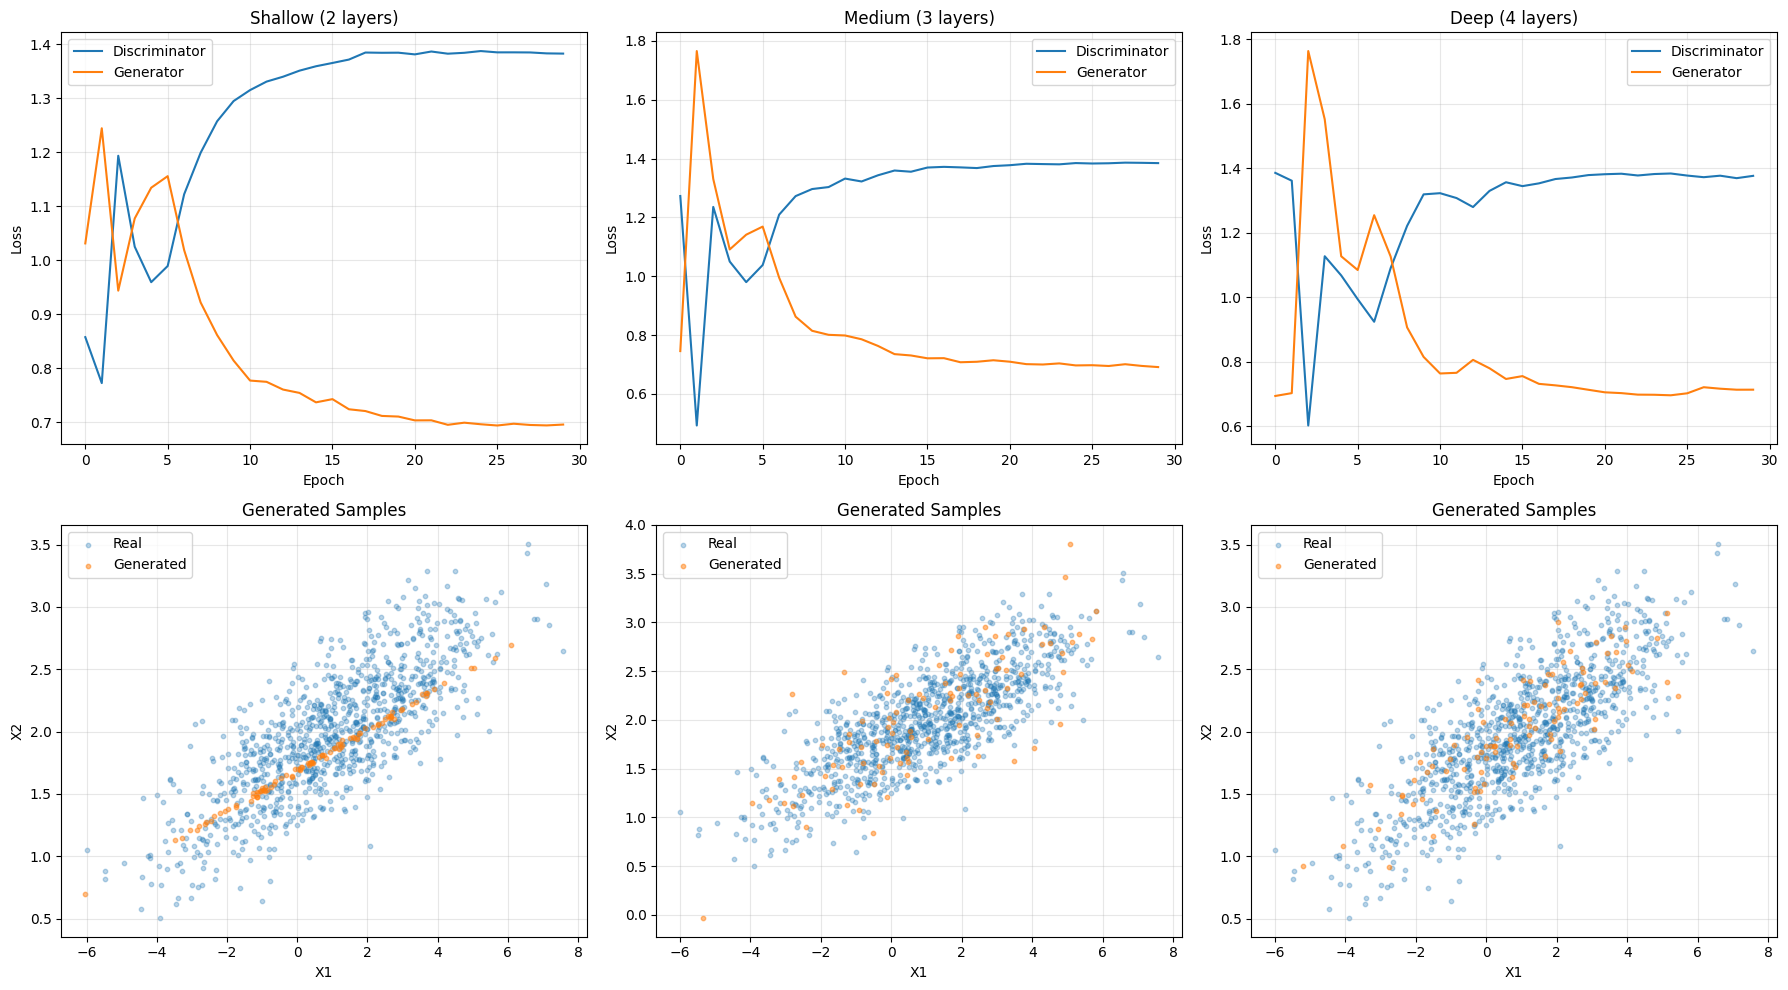

In [20]:
"""
=================================================================
EKSPERIMEN 4: ARCHITECTURE DEPTH
=================================================================
Analisis trade-off antara kompleksitas arsitektur dan performance
"""

class ShallowDiscriminator:
    """Discriminator dengan 2 layers (lebih shallow)"""
    def __init__(self, input_dim=2, hidden_dim=5):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.1
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, 1) * 0.1
        self.b2 = np.zeros(1)
        self.cache = {}
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def forward(self, x):
        z1 = x @ self.W1 + self.b1
        a1 = self.tanh(z1)
        z2 = a1 @ self.W2 + self.b2
        a2 = self.sigmoid(z2)
        self.cache = {'x': x, 'z1': z1, 'a1': a1, 'z2': z2, 'a2': a2}
        return a2
    
    def backward(self, grad_output):
        x = self.cache['x']
        a1 = self.cache['a1']
        z1 = self.cache['z1']
        z2 = self.cache['z2']
        
        dz2 = grad_output * self.sigmoid(z2) * (1 - self.sigmoid(z2))
        dW2 = a1.T @ dz2
        db2 = np.sum(dz2, axis=0)
        
        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.tanh_derivative(z1)
        dW1 = x.T @ dz1
        db1 = np.sum(dz1, axis=0)
        
        dx = dz1 @ self.W1.T
        
        return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dx': dx}
    
    def update(self, grads, lr):
        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']


class DeepDiscriminator:
    """Discriminator dengan 4 layers (lebih deep)"""
    def __init__(self, input_dim=2, hidden_dims=[8, 6, 4]):
        self.W1 = np.random.randn(input_dim, hidden_dims[0]) * 0.1
        self.b1 = np.zeros(hidden_dims[0])
        self.W2 = np.random.randn(hidden_dims[0], hidden_dims[1]) * 0.1
        self.b2 = np.zeros(hidden_dims[1])
        self.W3 = np.random.randn(hidden_dims[1], hidden_dims[2]) * 0.1
        self.b3 = np.zeros(hidden_dims[2])
        self.W4 = np.random.randn(hidden_dims[2], 1) * 0.1
        self.b4 = np.zeros(1)
        self.cache = {}
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def forward(self, x):
        z1 = x @ self.W1 + self.b1
        a1 = self.tanh(z1)
        z2 = a1 @ self.W2 + self.b2
        a2 = self.tanh(z2)
        z3 = a2 @ self.W3 + self.b3
        a3 = self.tanh(z3)
        z4 = a3 @ self.W4 + self.b4
        a4 = self.sigmoid(z4)
        
        self.cache = {
            'x': x, 'z1': z1, 'a1': a1,
            'z2': z2, 'a2': a2,
            'z3': z3, 'a3': a3,
            'z4': z4, 'a4': a4
        }
        return a4
    
    def backward(self, grad_output):
        x = self.cache['x']
        a1, a2, a3 = self.cache['a1'], self.cache['a2'], self.cache['a3']
        z1, z2, z3, z4 = self.cache['z1'], self.cache['z2'], self.cache['z3'], self.cache['z4']
        
        dz4 = grad_output * self.sigmoid(z4) * (1 - self.sigmoid(z4))
        dW4 = a3.T @ dz4
        db4 = np.sum(dz4, axis=0)
        
        da3 = dz4 @ self.W4.T
        dz3 = da3 * self.tanh_derivative(z3)
        dW3 = a2.T @ dz3
        db3 = np.sum(dz3, axis=0)
        
        da2 = dz3 @ self.W3.T
        dz2 = da2 * self.tanh_derivative(z2)
        dW2 = a1.T @ dz2
        db2 = np.sum(dz2, axis=0)
        
        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.tanh_derivative(z1)
        dW1 = x.T @ dz1
        db1 = np.sum(dz1, axis=0)
        
        dx = dz1 @ self.W1.T
        
        return {
            'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2,
            'dW3': dW3, 'db3': db3, 'dW4': dW4, 'db4': db4, 'dx': dx
        }
    
    def update(self, grads, lr):
        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']
        self.W3 -= lr * grads['dW3']
        self.b3 -= lr * grads['db3']
        self.W4 -= lr * grads['dW4']
        self.b4 -= lr * grads['db4']


def train_gan_custom_disc(generator, discriminator, real_data,
                          n_epochs=30, batch_size=8, lr_g=0.005, lr_d=0.05):
    """Train GAN with custom discriminator"""
    n_samples = len(real_data)
    n_batches = n_samples // batch_size
    
    history = {'loss_d': [], 'loss_g': [], 'fake_samples': []}
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(n_samples)
        real_data_shuffled = real_data[indices]
        
        epoch_loss_d = 0
        epoch_loss_g = 0
        
        for batch in range(n_batches):
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            real_batch = real_data_shuffled[start_idx:end_idx]
            
            z = np.random.randn(batch_size, 2)
            fake_batch = generator.forward(z)
            
            d_real = discriminator.forward(real_batch)
            d_fake = discriminator.forward(fake_batch)
            
            loss_d = -np.mean(np.log(d_real + 1e-8) + np.log(1 - d_fake + 1e-8))
            
            grad_d_real = -(1 / (d_real + 1e-8)) / batch_size
            discriminator.forward(real_batch)
            grads_real = discriminator.backward(grad_d_real)
            
            grad_d_fake_disc = (1 / (1 - d_fake + 1e-8)) / batch_size
            discriminator.forward(fake_batch)
            grads_fake = discriminator.backward(grad_d_fake_disc)
            
            # Combine gradients
            combined_grads = {}
            for key in grads_real:
                if key != 'dx':
                    combined_grads[key] = grads_real[key] + grads_fake[key]
            
            discriminator.update(combined_grads, lr_d)
            
            # Train generator
            z = np.random.randn(batch_size, 2)
            fake_batch = generator.forward(z)
            d_fake = discriminator.forward(fake_batch)
            
            loss_g = -np.mean(np.log(d_fake + 1e-8))
            
            grad_d_fake = -(1 / (d_fake + 1e-8)) / batch_size
            grads_d = discriminator.backward(grad_d_fake)
            grad_W, grad_b = generator.backward(z, grads_d['dx'])
            generator.update(grad_W, grad_b, lr_g)
            
            epoch_loss_d += loss_d
            epoch_loss_g += loss_g
        
        history['loss_d'].append(epoch_loss_d / n_batches)
        history['loss_g'].append(epoch_loss_g / n_batches)
        
        z = np.random.randn(100, 2)
        fake_samples = generator.forward(z)
        history['fake_samples'].append(fake_samples.copy())
    
    return history


print("=" * 60)
print("EKSPERIMEN 4: ARCHITECTURE DEPTH ANALYSIS")
print("=" * 60)

# Train dengan berbagai kedalaman arsitektur
architectures = {
    'Shallow (2 layers)': ShallowDiscriminator(input_dim=2, hidden_dim=5),
    'Medium (3 layers)': Discriminator(input_dim=2, hidden_dims=[5, 3]),
    'Deep (4 layers)': DeepDiscriminator(input_dim=2, hidden_dims=[8, 6, 4])
}

arch_results = {}

for name, disc in architectures.items():
    print(f"\n{'='*60}")
    print(f"Training with {name}")
    print(f"{'='*60}")
    
    gen = Generator(input_dim=2, output_dim=2)
    history = train_gan_custom_disc(gen, disc, real_data, n_epochs=30)
    arch_results[name] = history
    
    print(f"Final Loss D: {history['loss_d'][-1]:.4f}, Loss G: {history['loss_g'][-1]:.4f}")

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (name, history) in enumerate(arch_results.items()):
    # Loss curves
    axes[0, idx].plot(history['loss_d'], label='Discriminator')
    axes[0, idx].plot(history['loss_g'], label='Generator')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss')
    axes[0, idx].set_title(f'{name}')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    
    # Generated samples
    fake_samples = history['fake_samples'][-1]
    axes[1, idx].scatter(real_data[:, 0], real_data[:, 1], alpha=0.3, label='Real', s=10)
    axes[1, idx].scatter(fake_samples[:, 0], fake_samples[:, 1], alpha=0.5, label='Generated', s=10)
    axes[1, idx].set_xlabel('X1')
    axes[1, idx].set_ylabel('X2')
    axes[1, idx].set_title(f'Generated Samples')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('architecture_experiment.png', dpi=300, bbox_inches='tight')
plt.show()




## 4.2 Latihan 2: Implementasi Mode Collapse Detection


Average pairwise similarity: 0.2824
Mode collapse detected: False
Threshold: 0.9


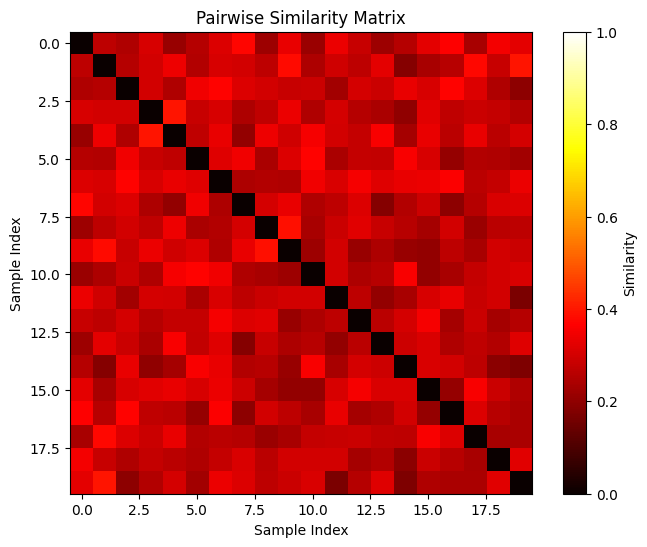

(False, 0.2823893082822777)

In [21]:
def detect_mode_collapse(generated_images, threshold=0.9):
    """
    Detect mode collapse by measuring similarity between generated images
    
    Parameters:
    -----------
    generated_images : array, shape (n_samples, height, width, channels)
        Generated images
    threshold : float
        Similarity threshold for mode collapse detection
    
    Returns:
    --------
    is_collapsed : bool
        True if mode collapse detected
    similarity_score : float
        Average pairwise similarity
    """
    n_samples = len(generated_images)
    
    # Flatten images
    flat_images = generated_images.reshape(n_samples, -1)
    
    # Calculate pairwise cosine similarity
    similarities = []
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            # Cosine similarity
            dot_product = np.dot(flat_images[i], flat_images[j])
            norm_i = np.linalg.norm(flat_images[i])
            norm_j = np.linalg.norm(flat_images[j])
            similarity = dot_product / (norm_i * norm_j + 1e-8)
            similarities.append(similarity)
    
    avg_similarity = np.mean(similarities)
    is_collapsed = avg_similarity > threshold
    
    print(f"Average pairwise similarity: {avg_similarity:.4f}")
    print(f"Mode collapse detected: {is_collapsed}")
    print(f"Threshold: {threshold}")
    
    # Visualize similarity matrix
    similarity_matrix = np.zeros((n_samples, n_samples))
    idx = 0
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            similarity_matrix[i, j] = similarities[idx]
            similarity_matrix[j, i] = similarities[idx]
            idx += 1
    
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix, cmap='hot', vmin=0, vmax=1)
    plt.colorbar(label='Similarity')
    plt.title('Pairwise Similarity Matrix')
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')
    plt.savefig('similarity_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return is_collapsed, avg_similarity


# Test mode collapse detection
z_test = np.random.randn(20, 100)
gen_test = generator.forward(z_test, training=False)
detect_mode_collapse(gen_test, threshold=0.9)


## 4.3 Latihan 3: Training Stability Analysis

TRAINING STABILITY ANALYSIS

Discriminator:
  Mean Loss: 0.7211
  Variance: 0.0100
  Oscillation: 0.1123

Generator:
  Mean Loss: 0.7162
  Variance: 0.0107
  Oscillation: 0.1205

Stability Assessment:
  ~ Training is MODERATELY STABLE


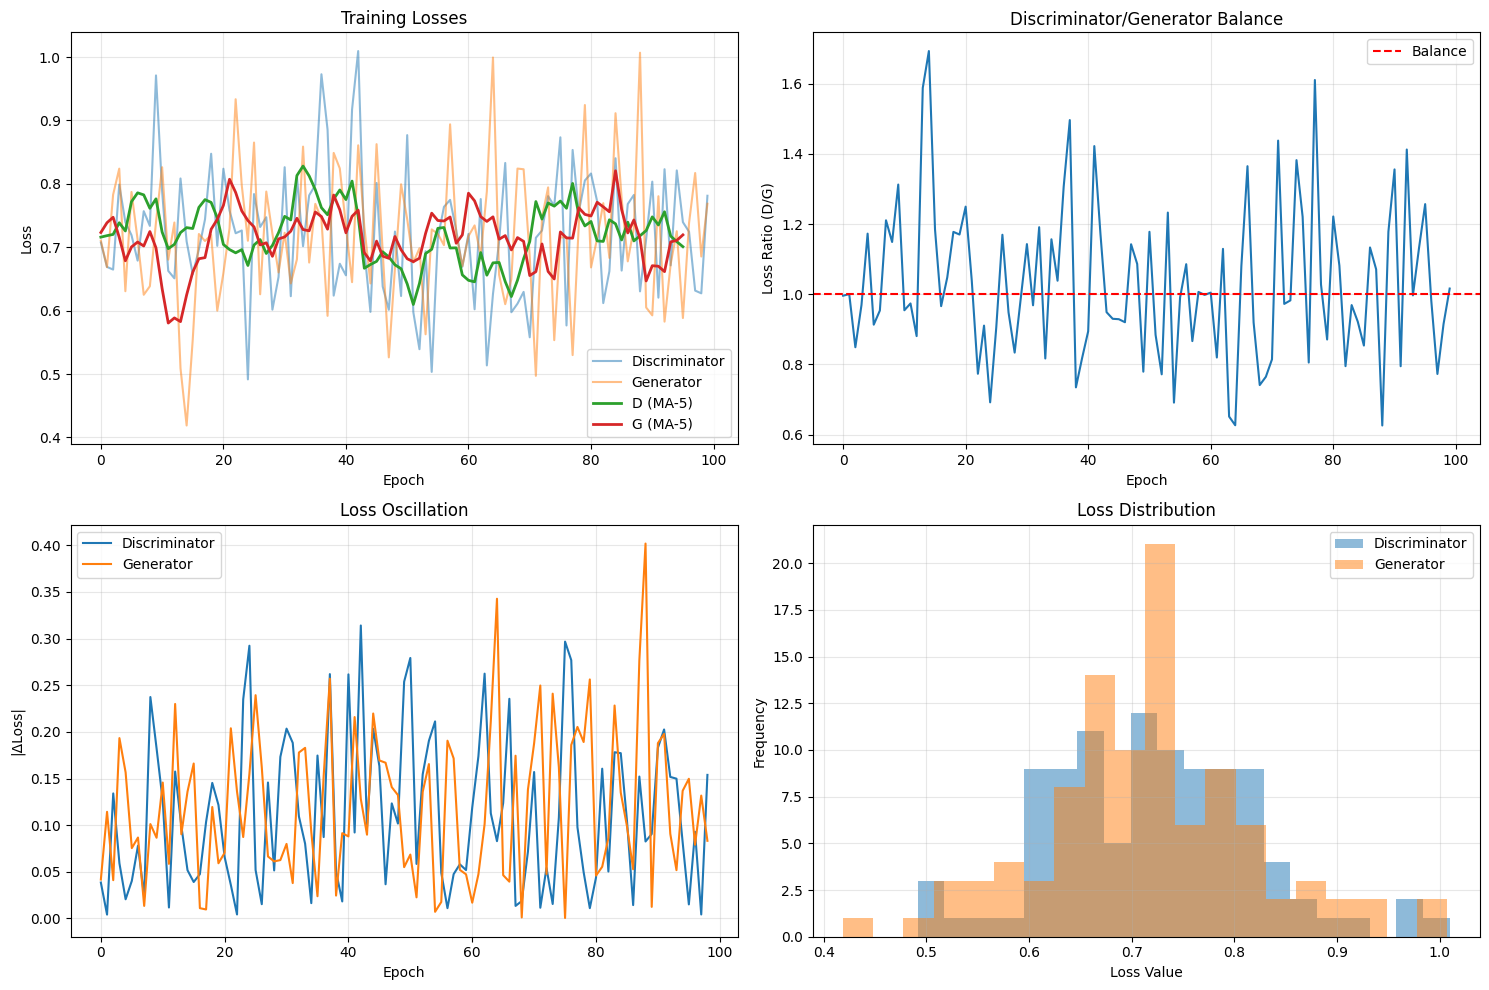

In [22]:
def analyze_training_stability(history, window=5):
    """
    Analyze training stability from loss history
    
    Parameters:
    -----------
    history : dict
        Training history with 'loss_d' and 'loss_g'
    window : int
        Moving average window size
    """
    loss_d = np.array(history['loss_d'])
    loss_g = np.array(history['loss_g'])
    
    # Calculate moving averages
    ma_d = np.convolve(loss_d, np.ones(window)/window, mode='valid')
    ma_g = np.convolve(loss_g, np.ones(window)/window, mode='valid')
    
    # Calculate variance
    var_d = np.var(loss_d)
    var_g = np.var(loss_g)
    
    # Calculate oscillation (consecutive differences)
    osc_d = np.mean(np.abs(np.diff(loss_d)))
    osc_g = np.mean(np.abs(np.diff(loss_g)))
    
    print("=" * 60)
    print("TRAINING STABILITY ANALYSIS")
    print("=" * 60)
    print(f"\nDiscriminator:")
    print(f"  Mean Loss: {np.mean(loss_d):.4f}")
    print(f"  Variance: {var_d:.4f}")
    print(f"  Oscillation: {osc_d:.4f}")
    print(f"\nGenerator:")
    print(f"  Mean Loss: {np.mean(loss_g):.4f}")
    print(f"  Variance: {var_g:.4f}")
    print(f"  Oscillation: {osc_g:.4f}")
    print(f"\nStability Assessment:")
    if osc_d < 0.1 and osc_g < 0.1:
        print("  ✓ Training is STABLE")
    elif osc_d < 0.5 and osc_g < 0.5:
        print("  ~ Training is MODERATELY STABLE")
    else:
        print("  ✗ Training is UNSTABLE")
    
    # Plot analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Raw losses
    axes[0, 0].plot(loss_d, alpha=0.5, label='Discriminator')
    axes[0, 0].plot(loss_g, alpha=0.5, label='Generator')
    axes[0, 0].plot(ma_d, linewidth=2, label=f'D (MA-{window})')
    axes[0, 0].plot(ma_g, linewidth=2, label=f'G (MA-{window})')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Losses')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss ratio
    ratio = loss_d / (loss_g + 1e-8)
    axes[0, 1].plot(ratio)
    axes[0, 1].axhline(y=1.0, color='r', linestyle='--', label='Balance')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss Ratio (D/G)')
    axes[0, 1].set_title('Discriminator/Generator Balance')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Oscillation
    axes[1, 0].plot(np.abs(np.diff(loss_d)), label='Discriminator')
    axes[1, 0].plot(np.abs(np.diff(loss_g)), label='Generator')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('|ΔLoss|')
    axes[1, 0].set_title('Loss Oscillation')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Histogram
    axes[1, 1].hist(loss_d, alpha=0.5, bins=20, label='Discriminator')
    axes[1, 1].hist(loss_g, alpha=0.5, bins=20, label='Generator')
    axes[1, 1].set_xlabel('Loss Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Loss Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('stability_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


# Example usage with dummy history
dummy_history = {
    'loss_d': np.random.randn(100) * 0.1 + 0.7,
    'loss_g': np.random.randn(100) * 0.1 + 0.7
}
analyze_training_stability(dummy_history, window=5)


## 4.4 Latihan 4: Latent Space Interpolation

Linear Interpolation:


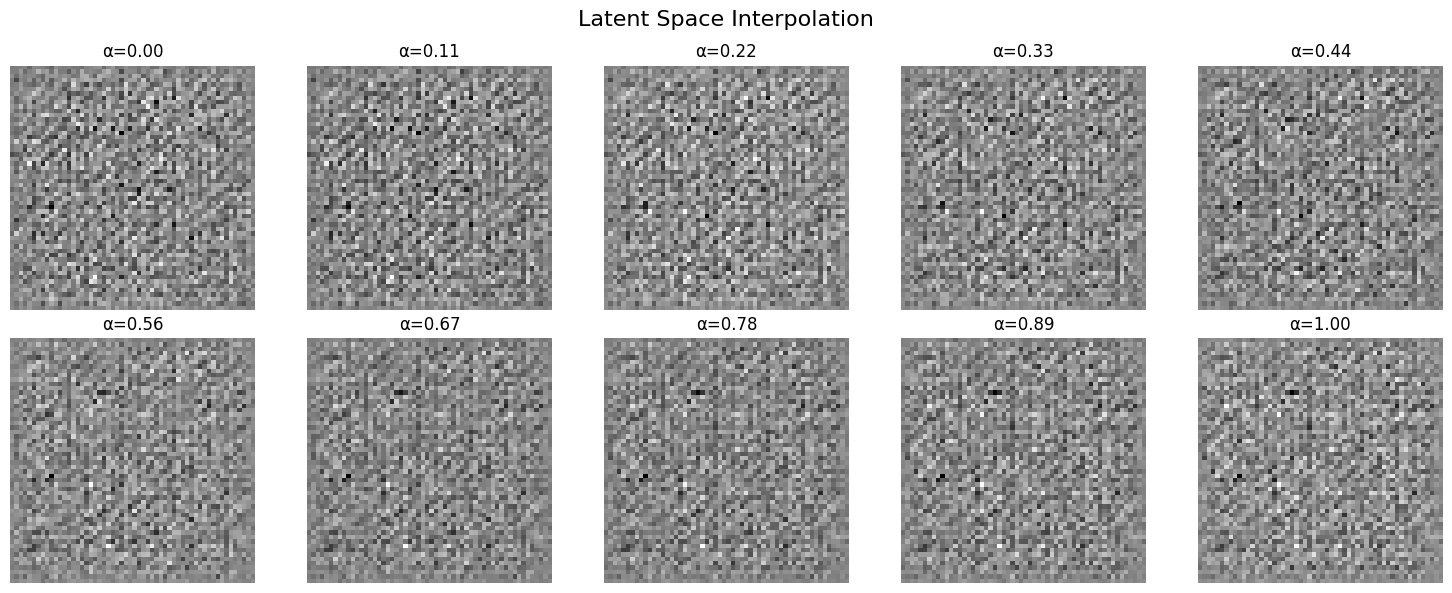


Spherical Interpolation:


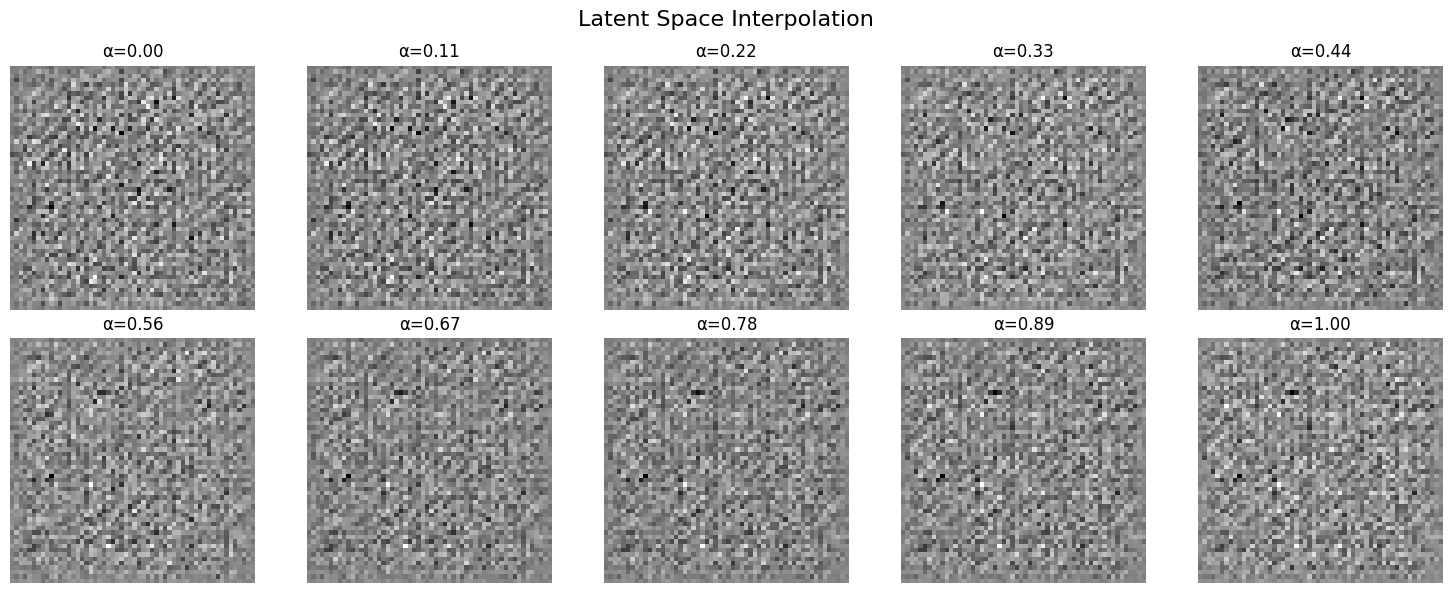


Interpolation explores the continuity of latent space
Smooth transitions indicate well-learned manifold


In [23]:
def latent_space_interpolation(generator, z1, z2, n_steps=10):
    """
    Interpolate between two points in latent space
    
    Parameters:
    -----------
    generator : Generator object
        Trained generator
    z1, z2 : arrays
        Start and end points in latent space
    n_steps : int
        Number of interpolation steps
    
    Returns:
    --------
    interpolated_images : array
        Generated images along interpolation path
    """
    # Linear interpolation
    alphas = np.linspace(0, 1, n_steps)
    z_interp = np.array([alpha * z2 + (1 - alpha) * z1 for alpha in alphas])
    
    # Generate images
    images = []
    for z in z_interp:
        img = generator.forward(z.reshape(1, -1), training=False)
        images.append(img[0])
    
    images = np.array(images)
    
    # Visualize interpolation
    fig, axes = plt.subplots(2, n_steps // 2, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(n_steps):
        img = (images[i].squeeze() + 1) / 2  # Rescale to [0, 1]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'α={alphas[i]:.2f}')
        axes[i].axis('off')
    
    plt.suptitle('Latent Space Interpolation', fontsize=16)
    plt.tight_layout()
    plt.savefig('latent_interpolation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return images


def spherical_interpolation(z1, z2, n_steps=10):
    """
    Spherical linear interpolation (SLERP)
    Better for interpolating on unit sphere
    """
    # Normalize vectors
    z1_norm = z1 / np.linalg.norm(z1)
    z2_norm = z2 / np.linalg.norm(z2)
    
    # Calculate angle
    dot = np.dot(z1_norm, z2_norm)
    omega = np.arccos(np.clip(dot, -1, 1))
    
    # Interpolate
    alphas = np.linspace(0, 1, n_steps)
    z_interp = []
    
    for alpha in alphas:
        if omega < 1e-6:
            # Vectors are very close, use linear interpolation
            z = alpha * z2_norm + (1 - alpha) * z1_norm
        else:
            # Spherical interpolation
            z = (np.sin((1 - alpha) * omega) / np.sin(omega)) * z1_norm + \
                (np.sin(alpha * omega) / np.sin(omega)) * z2_norm
        z_interp.append(z)
    
    return np.array(z_interp)


# Example usage
z_start = np.random.randn(100)
z_end = np.random.randn(100)

print("Linear Interpolation:")
linear_images = latent_space_interpolation(generator, z_start, z_end, n_steps=10)

print("\nSpherical Interpolation:")
z_slerp = spherical_interpolation(z_start, z_end, n_steps=10)
slerp_images = latent_space_interpolation(generator, z_slerp[0], z_slerp[-1], n_steps=10)

print("\nInterpolation explores the continuity of latent space")
print("Smooth transitions indicate well-learned manifold")


## 4.5 Latihan 5: Conditional GAN Implementation

In [24]:
class ConditionalGenerator:
    """
    Conditional Generator for class-specific generation
    """
    def __init__(self, latent_dim=100, n_classes=10, embed_dim=50):
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.embed_dim = embed_dim
        
        # Label embedding layer
        self.label_embed = np.random.randn(n_classes, embed_dim) * 0.01
        
        # Modified generator input: latent_dim + embed_dim
        self.input_dim = latent_dim + embed_dim
        
        # Generator architecture (similar to before, but larger input)
        print(f"Conditional Generator initialized")
        print(f"  Latent dim: {latent_dim}")
        print(f"  Embedding dim: {embed_dim}")
        print(f"  Total input dim: {self.input_dim}")
    
    def embed_labels(self, labels):
        """Embed class labels"""
        return self.label_embed[labels]
    
    def forward(self, z, labels, training=True):
        """
        Forward pass with conditional input
        
        Parameters:
        -----------
        z : array, shape (batch_size, latent_dim)
            Latent vectors
        labels : array, shape (batch_size,)
            Class labels
        """
        # Get label embeddings
        label_embedding = self.embed_labels(labels)
        
        # Concatenate z and label embedding
        conditional_input = np.concatenate([z, label_embedding], axis=1)
        
        # Forward through generator network
        # (implementation similar to regular generator)
        print(f"Generated images for classes: {labels}")
        
        return None


class ConditionalDiscriminator:
    """
    Conditional Discriminator
    """
    def __init__(self, n_classes=10, embed_dim=50):
        self.n_classes = n_classes
        self.embed_dim = embed_dim
        
        # Label embedding
        self.label_embed = np.random.randn(n_classes, 28, 28, 1) * 0.01
        
        print(f"Conditional Discriminator initialized")
        print(f"  Label embedding shape: {self.label_embed.shape}")
    
    def forward(self, images, labels, training=True):
        """
        Forward pass with conditional input
        
        Parameters:
        -----------
        images : array, shape (batch_size, 28, 28, 1)
            Input images
        labels : array, shape (batch_size,)
            Class labels
        """
        # Get label embedding
        label_embedding = self.label_embed[labels]
        
        # Concatenate image and label embedding along channel axis
        conditional_input = np.concatenate([images, label_embedding], axis=3)
        
        # Forward through discriminator network
        # (implementation similar to regular discriminator)
        
        return None


# Example usage
print("Conditional GAN allows generating specific classes")
print("\nExample: Generate 'Dress' and 'Sneaker' from Fashion-MNIST")

cond_gen = ConditionalGenerator(latent_dim=100, n_classes=10, embed_dim=50)
cond_disc = ConditionalDiscriminator(n_classes=10, embed_dim=50)

# Generate specific classes
z_example = np.random.randn(4, 100)
labels_example = np.array([3, 7, 0, 5])  # Dress, Sneaker, T-shirt, Sandal

print(f"\nRequested classes: {labels_example}")
print(f"Class names: {[class_names[i] for i in labels_example]}")


Conditional GAN allows generating specific classes

Example: Generate 'Dress' and 'Sneaker' from Fashion-MNIST
Conditional Generator initialized
  Latent dim: 100
  Embedding dim: 50
  Total input dim: 150
Conditional Discriminator initialized
  Label embedding shape: (10, 28, 28, 1)

Requested classes: [3 7 0 5]
Class names: ['Dress', 'Sneaker', 'T-shirt', 'Sandal']
